# Assignment 4 - Neural Networks

## *Luopeiwen Yi*
Netid: ly178

*Names of students you worked with on this assignment*: Jiayi Zhou

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://kylebradbury.github.io/ids705/notebooks/assignment_instructions.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

In [279]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import seaborn.objects as so
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from time import time
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import loguniform
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("mode.copy_on_write", True)

%config InlineBackend.figure_format = 'retina'

# 1

## [60 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [281]:
# Optional for clear plotting on Macs
%config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with 
#  what's causing the warning and simply don't want to see it, we can use the 
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'

In [284]:
import numpy as np
from sklearn.model_selection import PredefinedSplit


# -----------------------------------------------------------------------------
# Create the data
# -----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n / 4)
    shift = 0.5
    c1a = np.random.randn(n_samples, 2) * noise + [-shift, shift]
    c1b = np.random.randn(n_samples, 2) * noise + [shift, -shift]
    c0a = np.random.randn(n_samples, 2) * noise + [shift, shift]
    c0b = np.random.randn(n_samples, 2) * noise + [-shift, -shift]
    X = np.concatenate((c1a, c1b, c0a, c0b), axis=0)
    y = np.concatenate((np.ones(2 * n_samples), np.zeros(2 * n_samples)))

    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X) > cutoff
    for index, value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand() * 2.5 - 1.25
    return (X, y)


# Training datasets
np.random.seed(42)
noise = 0.45
X_train, y_train = make_data_normal_checkerboard(500, noise=noise)

# Validation and test data
X_val, y_val = make_data_normal_checkerboard(500, noise=noise)
X_test, y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1 * np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

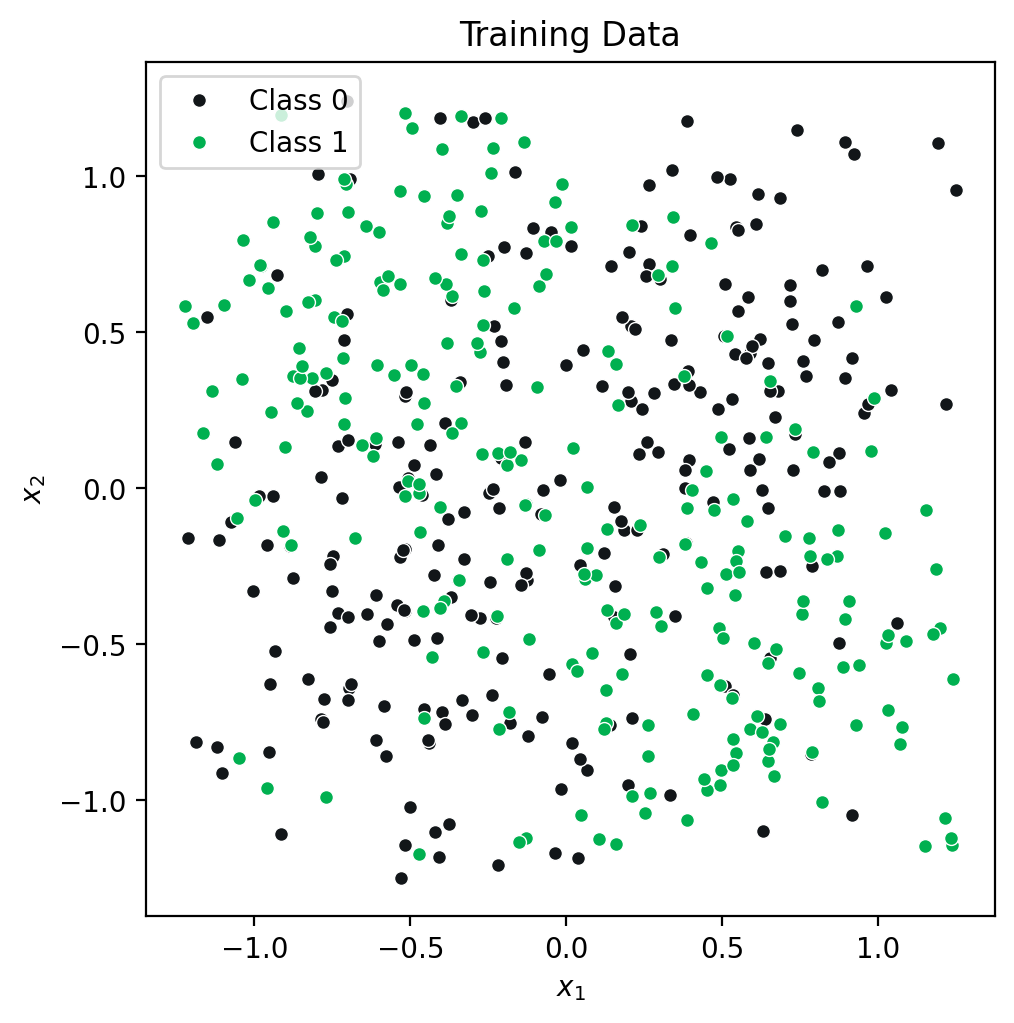

In [285]:
import matplotlib.pyplot as plt


# Code to plot the sample data
def plot_data(ax, X, y, title, limits):
    # Select the colors to use in the plots
    color0 = "#121619"  # Dark grey
    color1 = "#00B050"  # Green
    color_boundary = "#858585"

    # Separate samples by class
    samples0 = X[y == 0]
    samples1 = X[y == 1]

    ax.plot(
        samples0[:, 0],
        samples0[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 0",
    )
    ax.plot(
        samples1[:, 0],
        samples1[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 1",
    )
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.legend(loc="upper left")
    ax.set_aspect("equal")


fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, "Training Data", limits)

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

This should produce 12 plots, altogether. For easier comparison, please plot nodes & layers combinations, learning rates, regularization strengths, and batch sizes in four separate rows (with three columns each representing a different value for each of those hyperparameters). 

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

**ANSWER**

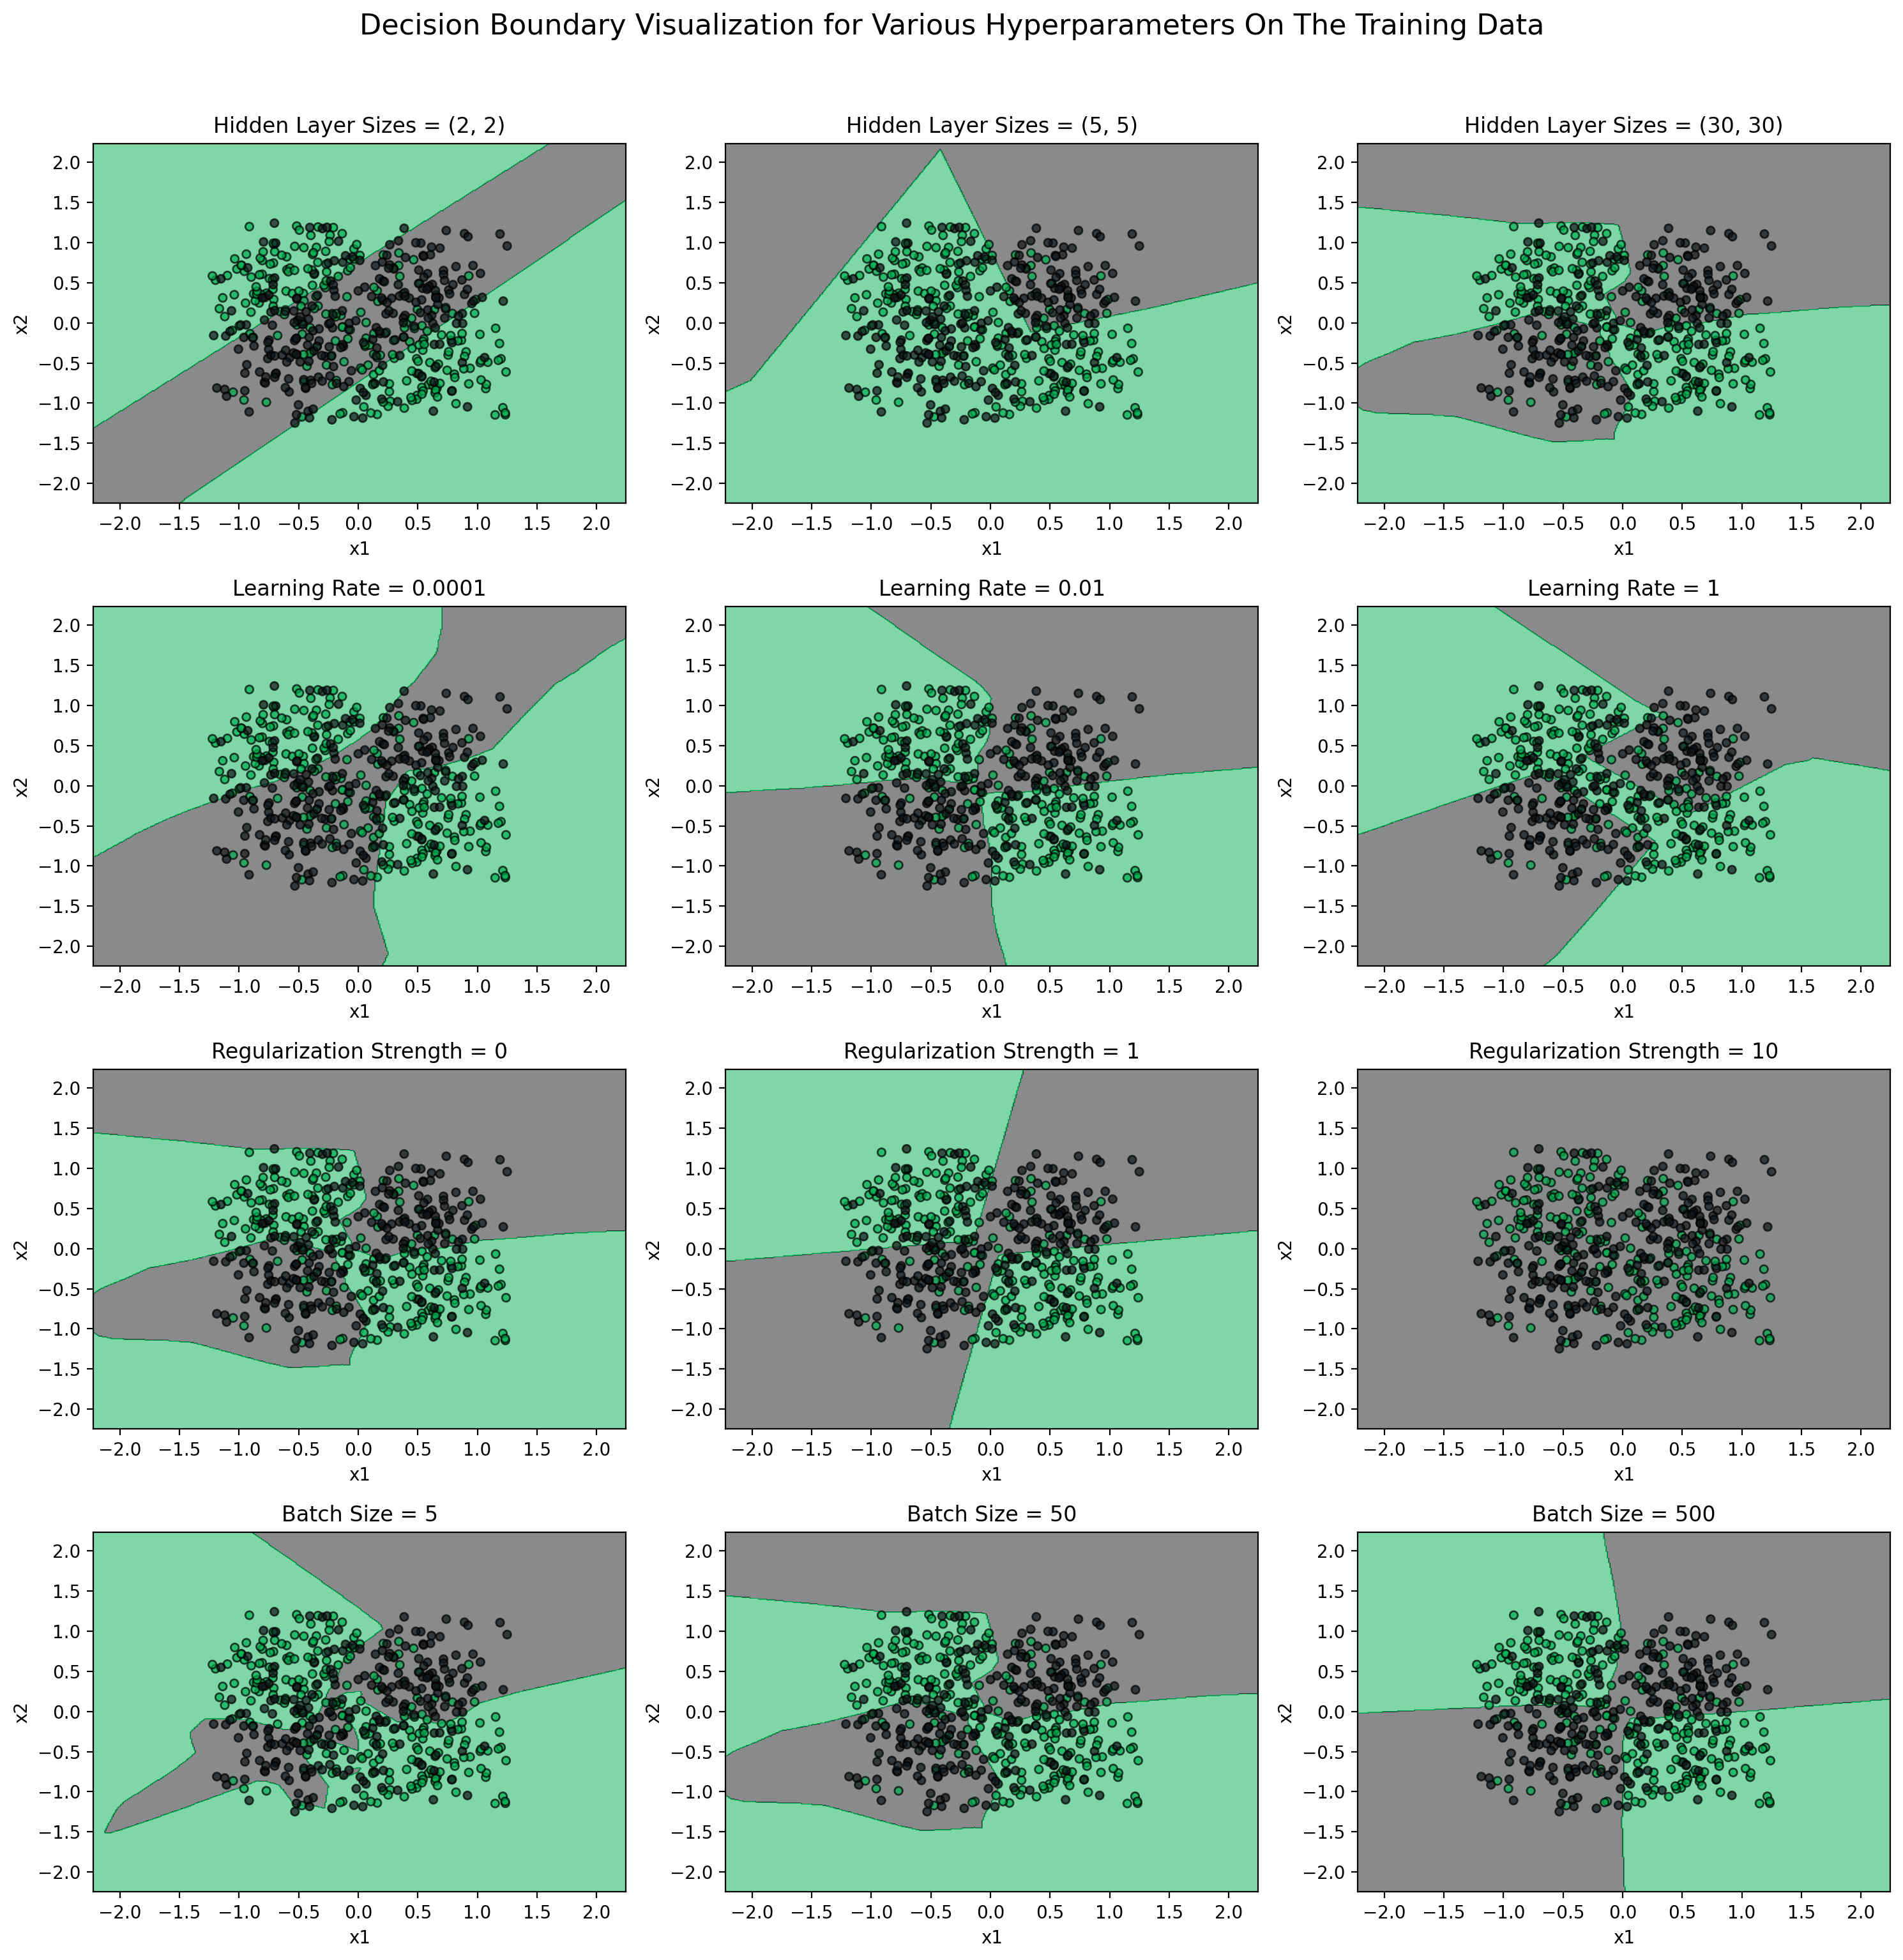

In [112]:
seed = 42
# Generate a mesh grid to plot the decision boundaries
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

# Define the hyperparameters and their values
hidden_layer_sizes_values = [(2, 2), (5, 5), (30, 30)]
learning_rate_values = [0.0001, 0.01, 1]
alpha_values = [0, 1, 10]
batch_size_values = [5, 50, 500]

# Define colors for plotting
color0 = "#121619"  # Dark grey
color1 = "#00B050"  # Green
color_boundary = "#858585"

# Define colors for plotting
colors = [color0, color1]  # Dark grey for class 0, Green for class 1
cmap = mcolors.ListedColormap(colors)

# Iterate over each hyperparameter and train the model
for i, (param_values, param_name) in enumerate(
    [
        (hidden_layer_sizes_values, "Hidden Layer Sizes"),
        (learning_rate_values, "Learning Rate"),
        (alpha_values, "Regularization Strength"),
        (batch_size_values, "Batch Size"),
    ]
):
    for j, value in enumerate(param_values):
        # Instantiate MLPClassifier with one hyperparameter varied
        if param_name == "Hidden Layer Sizes":
            mlp_clf = MLPClassifier(
                hidden_layer_sizes=value,
                learning_rate_init=0.03,
                alpha=0,
                solver="sgd",
                tol=1e-5,
                early_stopping=False,
                activation="relu",
                n_iter_no_change=1000,
                batch_size=50,
                max_iter=500,
                random_state=seed,
            )
        elif param_name == "Learning Rate":
            mlp_clf = MLPClassifier(
                learning_rate_init=value,
                hidden_layer_sizes=(30, 30),
                alpha=0,
                solver="sgd",
                tol=1e-5,
                early_stopping=False,
                activation="relu",
                n_iter_no_change=1000,
                batch_size=50,
                max_iter=500,
                random_state=seed,
            )
        elif param_name == "Regularization Strength":
            mlp_clf = MLPClassifier(
                alpha=value,
                hidden_layer_sizes=(30, 30),
                learning_rate_init=0.03,
                solver="sgd",
                tol=1e-5,
                early_stopping=False,
                activation="relu",
                n_iter_no_change=1000,
                batch_size=50,
                max_iter=500,
                random_state=seed,
            )
        elif param_name == "Batch Size":
            mlp_clf = MLPClassifier(
                batch_size=value,
                hidden_layer_sizes=(30, 30),
                learning_rate_init=0.03,
                alpha=0,
                solver="sgd",
                tol=1e-5,
                early_stopping=False,
                activation="relu",
                n_iter_no_change=1000,
                max_iter=500,
                random_state=seed,
            )

        # Train the model
        mlp_clf.fit(X_train, y_train)

        # Train the model and predict over the grid
        Z = mlp_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

        ax = axes[i, j]
        # Plot decision regions
        contour = ax.contourf(
            xx, yy, Z, cmap=cmap, alpha=0.5
        )  # Use the defined colormap

        # Plot training points
        ax.scatter(
            X_train[:, 0],
            X_train[:, 1],
            c=y_train,
            cmap=cmap,
            edgecolor="k",
            s=20,
            alpha=0.7,
        )

        # Set plot titles and labels
        ax.set_title(f"{param_name} = {value}")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

# Add a big title for all subplots
plt.suptitle(
    "Decision Boundary Visualization for Various Hyperparameters On The Training Data",
    fontsize=16,
    y=1.02,
)

plt.tight_layout()
plt.show()

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times (without fixing a random seed) and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

**ANSWER**

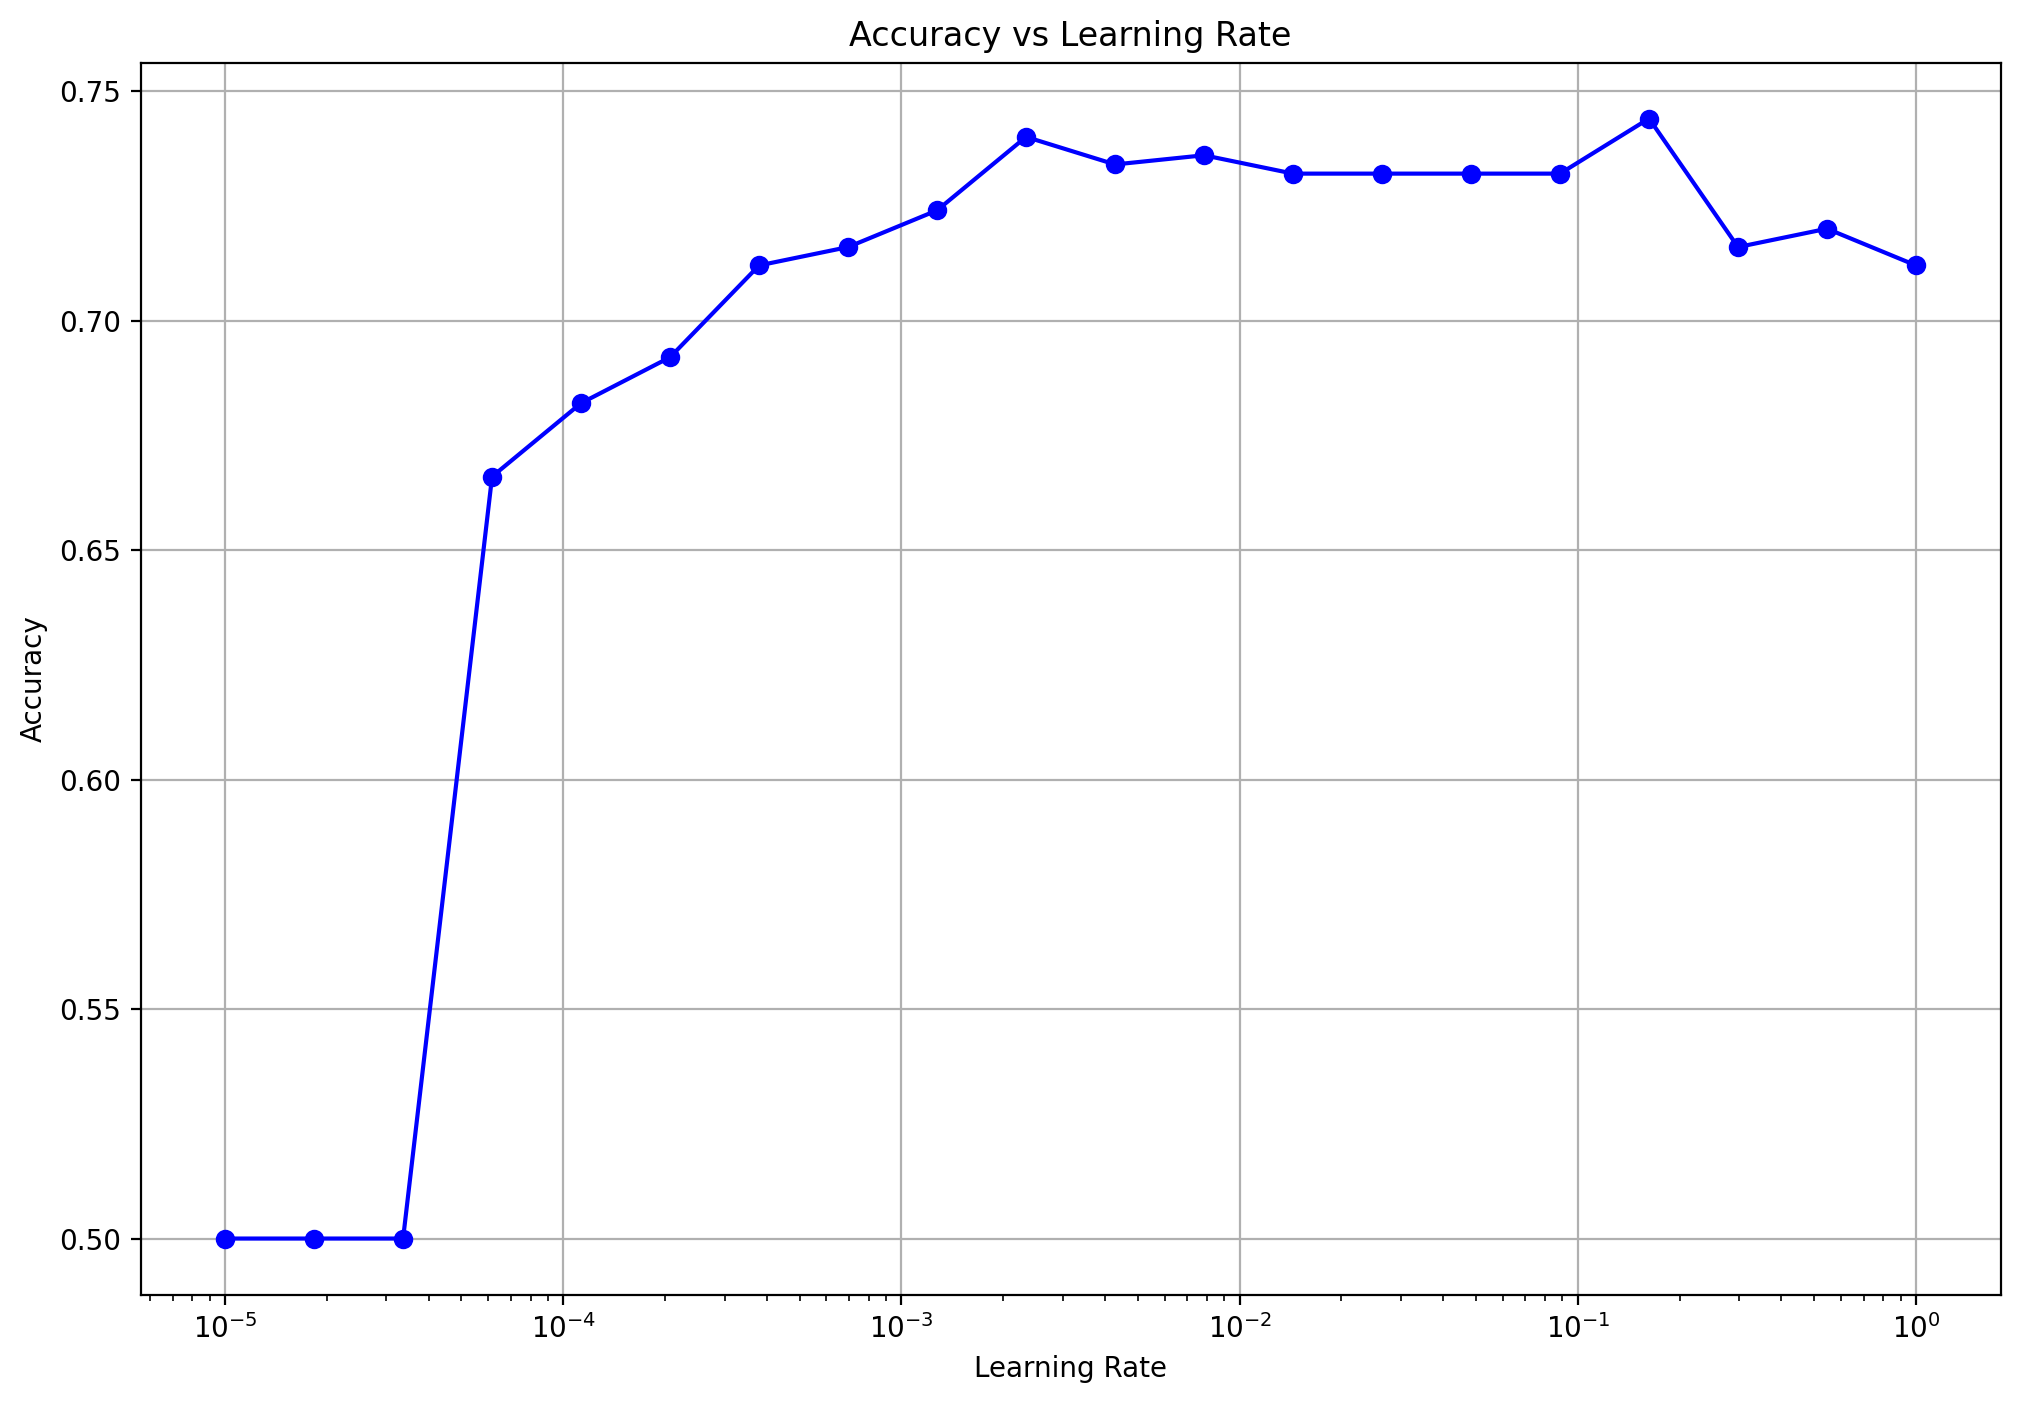

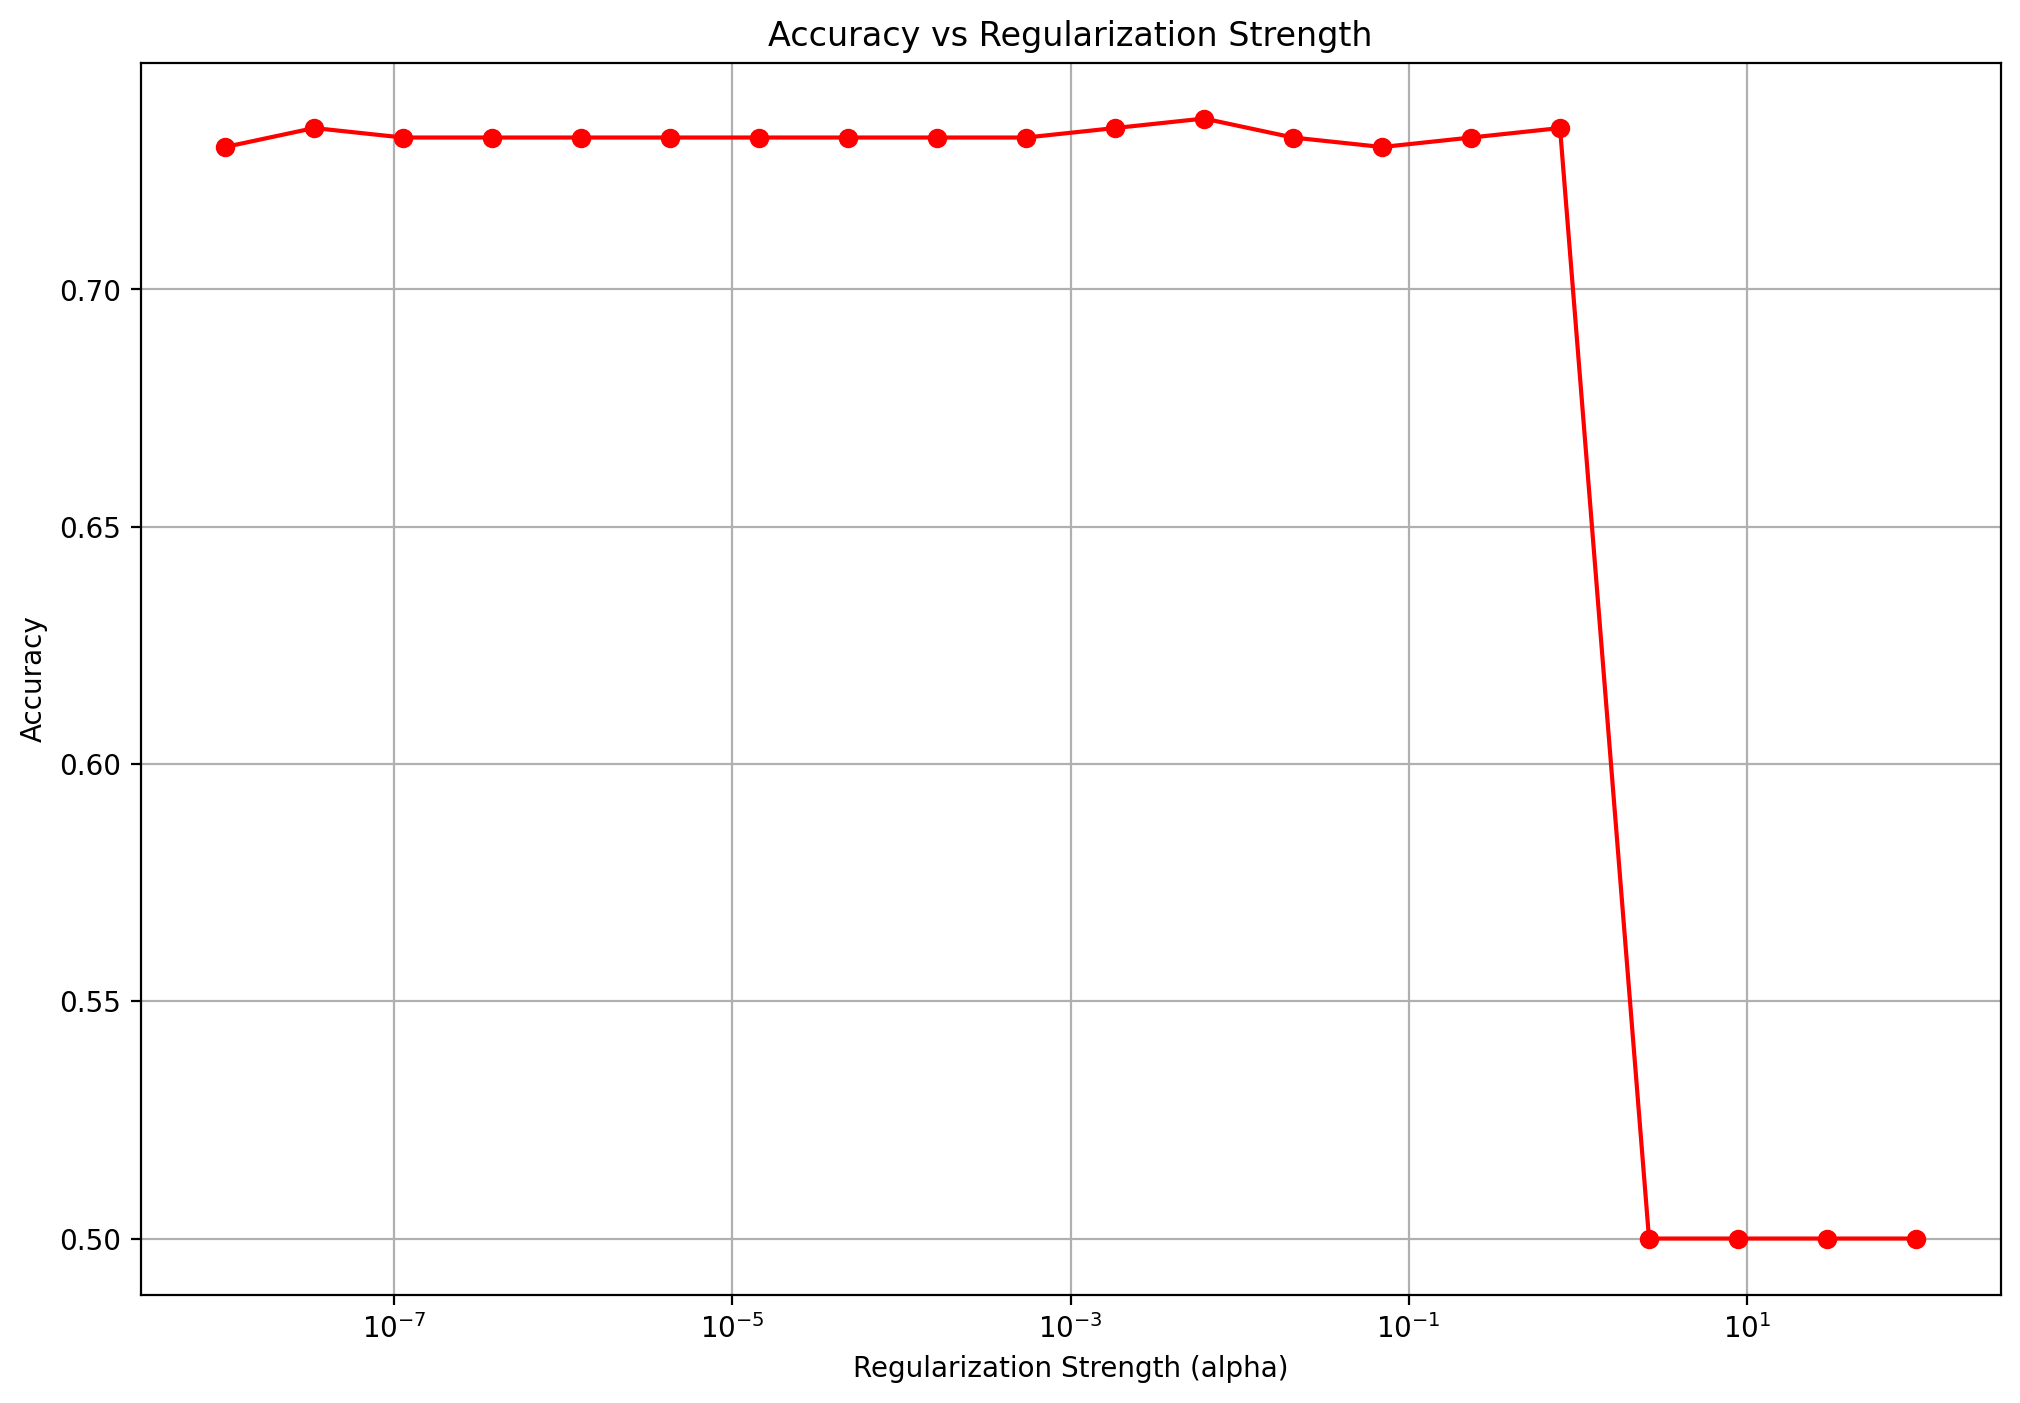

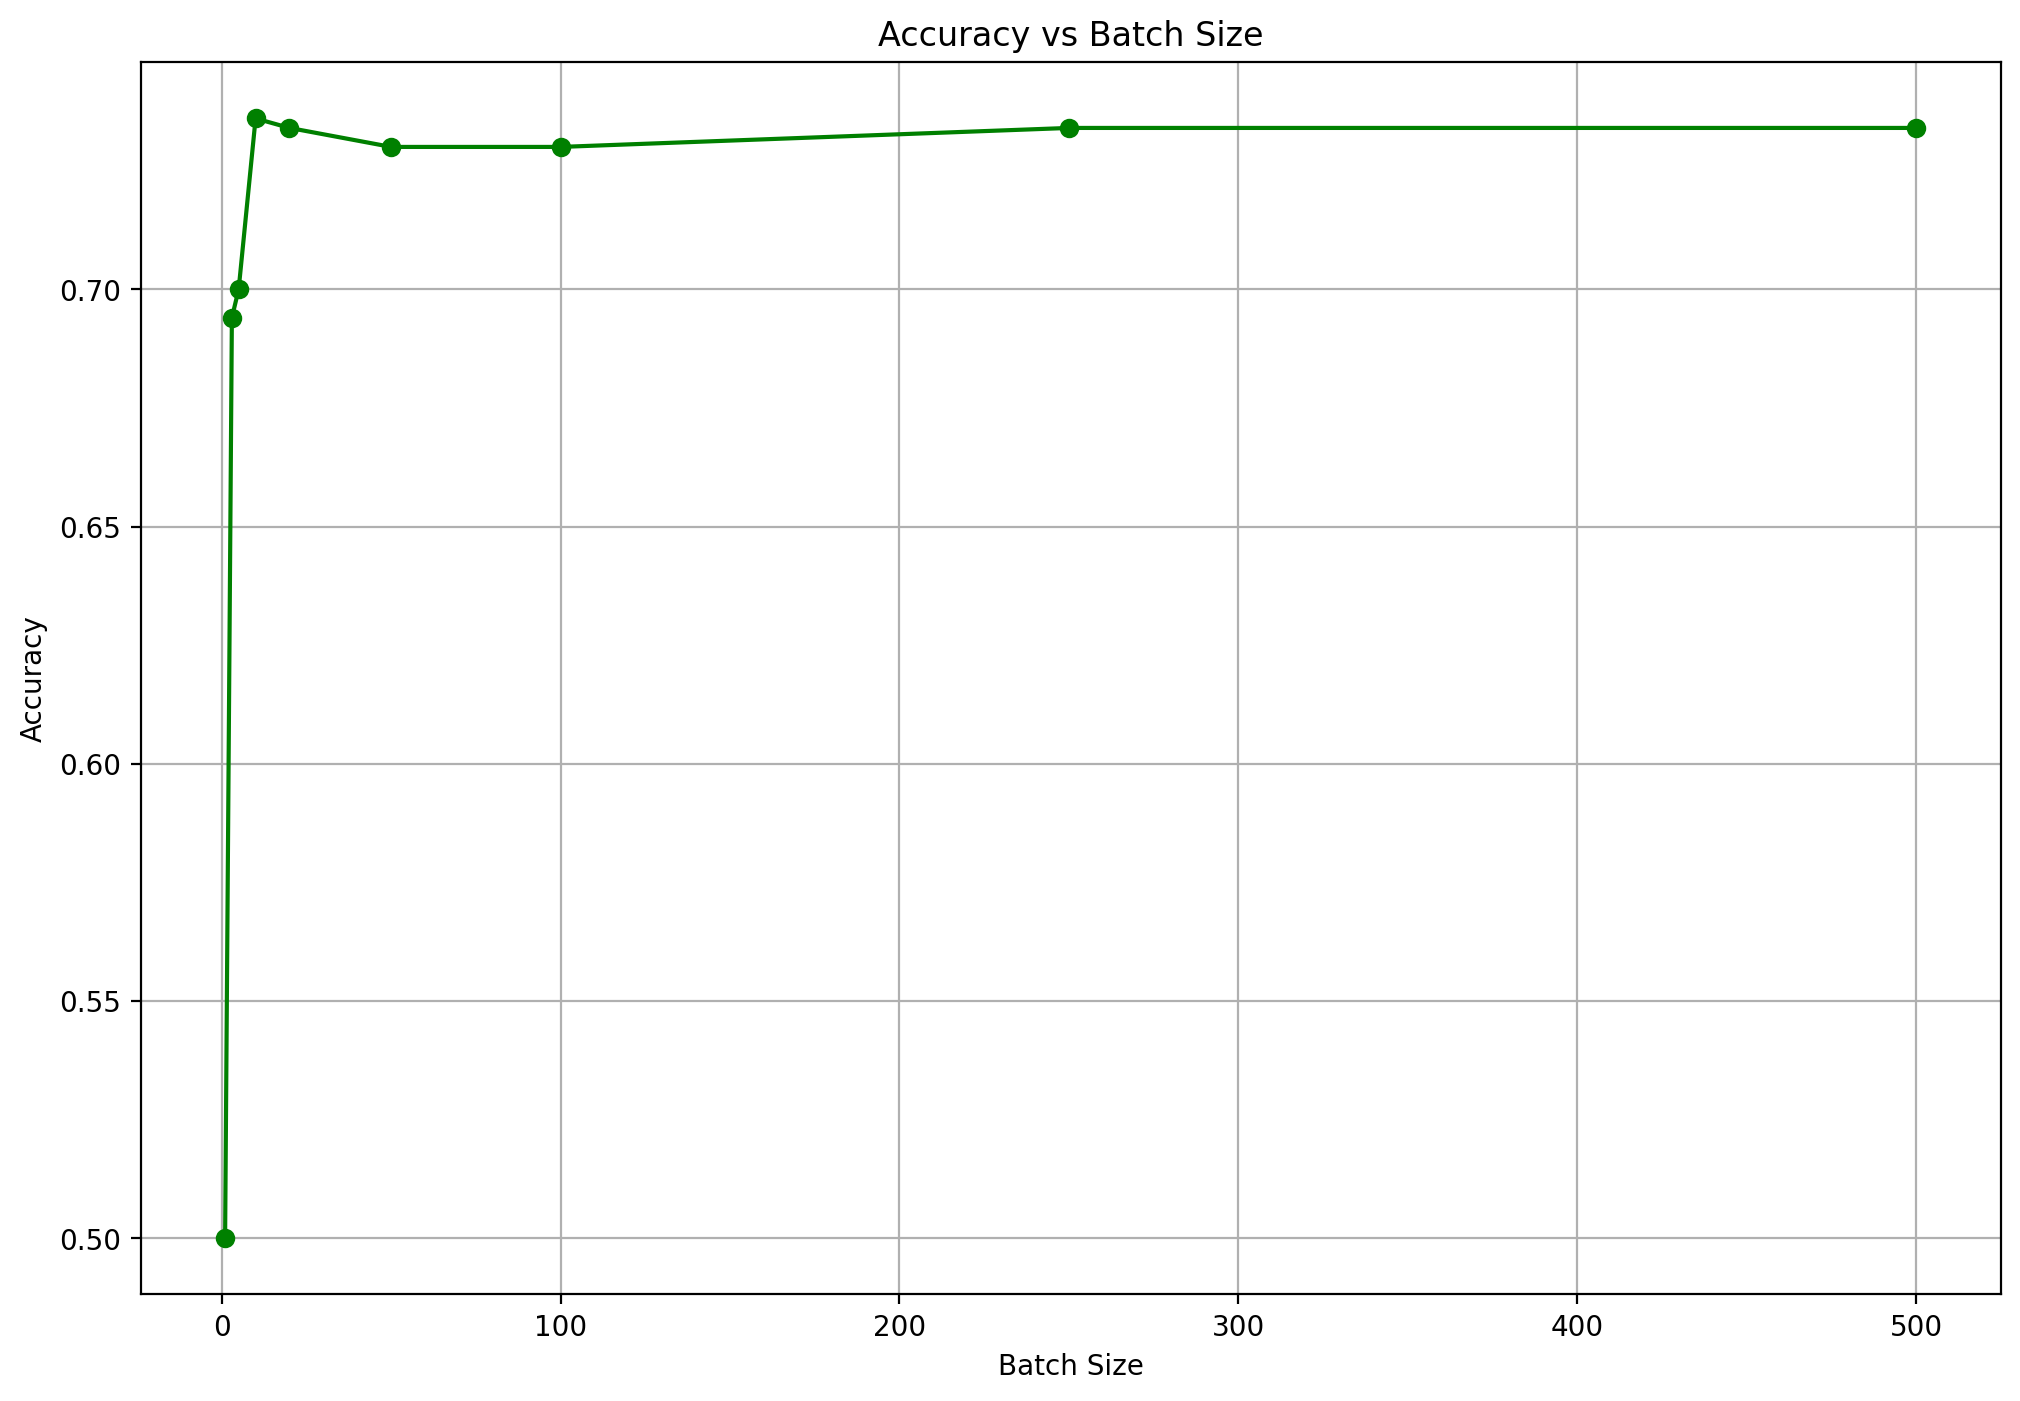

In [113]:
# Create the hyperparameter ranges
learning_rate_range = np.logspace(-5, 0, 20)
alpha_range = np.logspace(-8, 2, 20)
batch_size_range = [1, 3, 5, 10, 20, 50, 100, 250, 500]

# Prepare to collect accuracy results
learning_rate_accuracy = []
alpha_accuracy = []
batch_size_accuracy = []

# Test different learning rates
for value in learning_rate_range:
    mlp_clf = MLPClassifier(
        learning_rate_init=value,
        hidden_layer_sizes=(30, 30),
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        batch_size=50,
        max_iter=500,
        random_state=seed,
    )
    mlp_clf.fit(X_train, y_train)
    score = mlp_clf.score(X_val, y_val)
    learning_rate_accuracy.append(score)

# Test different alphas (regularization strengths)
for value in alpha_range:
    mlp_clf = MLPClassifier(
        alpha=value,
        hidden_layer_sizes=(30, 30),
        learning_rate_init=0.03,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        batch_size=50,
        max_iter=500,
        random_state=seed,
    )
    mlp_clf.fit(X_train, y_train)
    score = mlp_clf.score(X_val, y_val)
    alpha_accuracy.append(score)

# Test different batch sizes
for value in batch_size_range:
    mlp_clf = MLPClassifier(
        batch_size=value,
        hidden_layer_sizes=(30, 30),
        learning_rate_init=0.03,
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=1000,
        max_iter=500,
        random_state=seed,
    )
    mlp_clf.fit(X_train, y_train)
    score = mlp_clf.score(X_val, y_val)
    batch_size_accuracy.append(score)

# Learning Rate Plot
plt.figure(figsize=(12, 8))
plt.semilogx(
    learning_rate_range, learning_rate_accuracy, marker="o", linestyle="-", color="blue"
)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning Rate")
plt.grid(True)
plt.show()

# Alpha Plot
plt.figure(figsize=(12, 8))
plt.semilogx(alpha_range, alpha_accuracy, marker="o", linestyle="-", color="red")
plt.xlabel("Regularization Strength (alpha)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Regularization Strength")
plt.grid(True)
plt.show()

# Batch Size Plot
plt.figure(figsize=(12, 8))
plt.plot(
    batch_size_range, batch_size_accuracy, marker="o", linestyle="-", color="green"
)
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Batch Size")
plt.grid(True)
plt.show()

In [114]:
# Find the indices of the maximum accuracy
max_lr_index = np.argmax(learning_rate_accuracy)
max_alpha_index = np.argmax(alpha_accuracy)
max_batch_size_index = np.argmax(batch_size_accuracy)

# Find the corresponding hyperparameter values
best_learning_rate = learning_rate_range[max_lr_index]
best_alpha = alpha_range[max_alpha_index]
best_batch_size = batch_size_range[max_batch_size_index]

# Print out the best hyperparameter values and their accuracies
print(
    f"My optimal choise of Learning Rate is {best_learning_rate} because it has the Maximum Accuracy {learning_rate_accuracy[max_lr_index]}"
)
print(
    f"My optimal choise of Regularization Strength (alpha) is {best_alpha} because it has the Maximum Accuracy {alpha_accuracy[max_alpha_index]}"
)
print(
    f"My optimal choise of Batch Size is {best_batch_size} because it has the Maximum Accuracy {batch_size_accuracy[max_batch_size_index]}"
)

My optimal choise of Learning Rate is 0.1623776739188721 because it has the Maximum Accuracy 0.744
My optimal choise of Regularization Strength (alpha) is 0.006158482110660254 because it has the Maximum Accuracy 0.736
My optimal choise of Batch Size is 10 because it has the Maximum Accuracy 0.736


**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$

Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

**ANSWER**

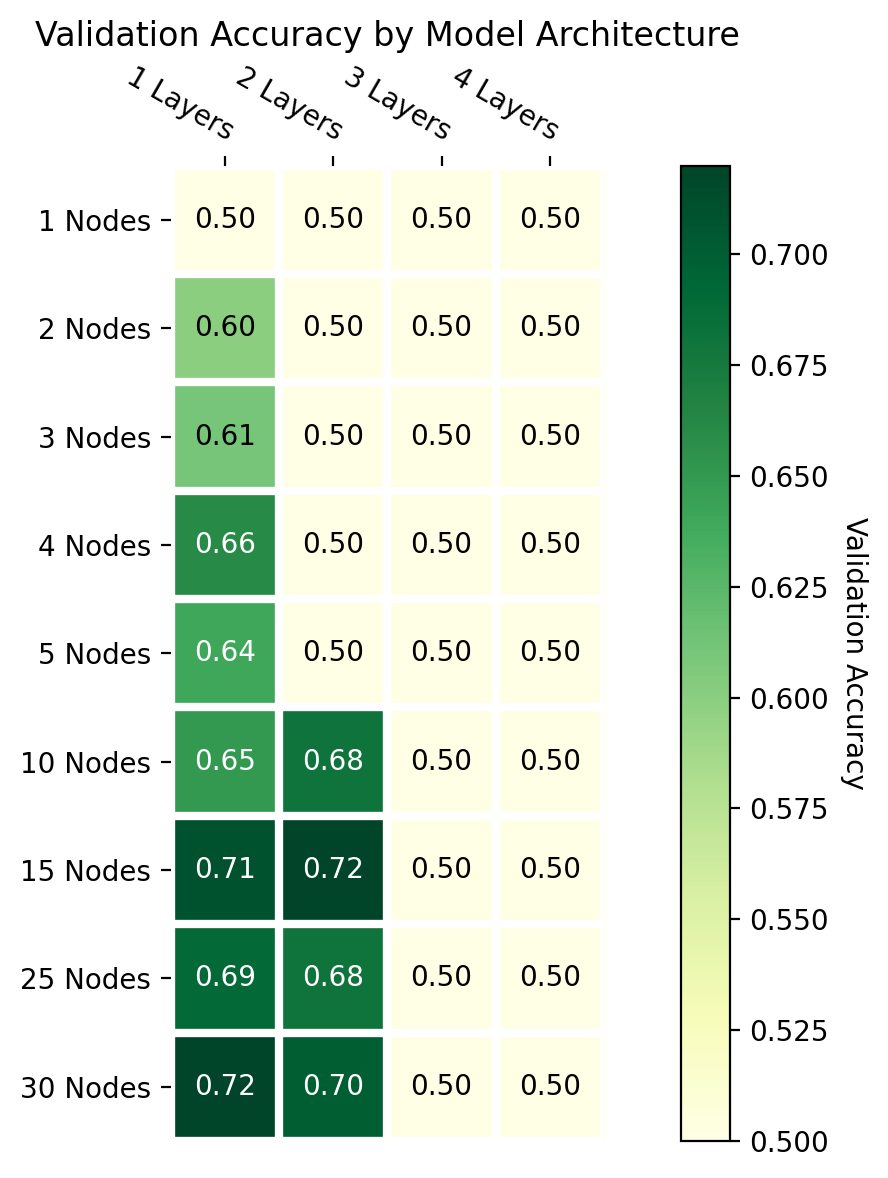

In [115]:
# Architecture design
nodes_per_layer = [1, 2, 3, 4, 5, 10, 15, 25, 30]
num_layers = [1, 2, 3, 4]

# Prepare to collect accuracy results
accuracy_results = np.zeros((len(nodes_per_layer), len(num_layers)))

for i, nodes in enumerate(nodes_per_layer):
    for j, layers in enumerate(num_layers):
        # Define the model with the current architecture
        hidden_layer_sizes = (nodes,) * layers
        # Use the best hyperparameters
        mlp_clf = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            learning_rate_init=best_learning_rate,
            alpha=best_alpha,
            solver="sgd",
            tol=1e-5,
            early_stopping=False,
            activation="relu",
            n_iter_no_change=1000,
            batch_size=best_batch_size,
            max_iter=500,
            random_state=seed,
        )

        # Train the model
        mlp_clf.fit(X_train, y_train)

        # Evaluate the model
        score = mlp_clf.score(X_val, y_val)
        accuracy_results[i, j] = round(score, 2)

# Labels for the heatmap
row_labels = [f"{n} Nodes" for n in nodes_per_layer]
col_labels = [f"{l} Layers" for l in num_layers]


def heatmap(
    data, row_labels, col_labels, ax=None, cbar_kw=None, cbarlabel="", **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(
    im,
    data=None,
    valfmt="{x:.2f}",
    textcolors=("black", "white"),
    threshold=None,
    **textkw,
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


# plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im, cbar = heatmap(
    accuracy_results,
    row_labels,
    col_labels,
    ax=ax,
    cmap="YlGn",
    cbarlabel="Validation Accuracy",
)
texts = annotate_heatmap(im, valfmt="{x:.2f}")

# title
ax.set_title("Validation Accuracy by Model Architecture")

fig.tight_layout()
plt.show()

In [122]:
I = 2  # 2 input features
O = 1  # 1 output node

# Model 1: 1 layer, 30 nodes
model1_weights = (I * 30 + 30) + (30 * O + O)

# Model 2: 2 layers, 15 nodes each
model2_weights = (
    (I * 15 + 15) + (15 * 15 + 15) + (15 * O + O)
)  # Account for each layer transition

print("Model 1 (1 layer, 30 nodes) Total Weights:", model1_weights)
print("Model 2 (2 layers, 15 nodes) Total Weights:", model2_weights)

# Choose model based on fewer weights
if model1_weights < model2_weights:
    print("Choose Model 1: It's simpler with fewer total weights.")
else:
    print("Choose Model 2: It's simpler with fewer total weights.")

Model 1 (1 layer, 30 nodes) Total Weights: 121
Model 2 (2 layers, 15 nodes) Total Weights: 301
Choose Model 1: It's simpler with fewer total weights.


> hyperparameter selection: number of layers = 1, nodes per layer = 30. I selected the model with the highest accuracy but lowest number of total model weights.

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

**ANSWER**

In [125]:
best_hidden_layer_size = (30,)  # 1 layer with 30 nodes
# Retrain with optimized hyperparameters on combined training and validation data
mlp_clf_optimized = MLPClassifier(
    hidden_layer_sizes=best_hidden_layer_size,
    learning_rate_init=best_learning_rate,
    alpha=best_alpha,
    batch_size=best_batch_size,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=1000,
    max_iter=500,
    random_state=seed,
)

# train the model on the combined training and validation data
mlp_clf_optimized.fit(X_train_plus_val, y_train_plus_val)

# Apply the trained model to the test data
y_pred_optimized = mlp_clf_optimized.predict(X_test)

# Report the accuracy on the test data
test_accuracy_greedy_optimization = accuracy_score(y_test, y_pred_optimized)
print(
    f"Final model accuracy on test data with best hyperparameters from greedy optimization: {test_accuracy_greedy_optimization:.4f}"
)

Final model accuracy on test data with best hyperparameters from greedy optimization: 0.7080


**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this. 
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to. *Note: The object returned by running fit (the random search) is NOT the best estimator. You can access the best estimator through the attribute `.best_estimator_`, assuming that you did not pass `refit=False`.*
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve. This should be one single graph with 3 curves (one for greedy search, one for random search, and one representing random chance). Please also provide AUC score for greedy research and random search. 
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

**ANSWER**

In [126]:
# Define the MLPClassifier with default settings
mlp_clf = MLPClassifier(
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=1000,
    max_iter=500,
    random_state=seed,
)


# Utility function to report best scores
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


# Define hyperparameters distributions to sample from
param_dist = {
    "hidden_layer_sizes": [
        (nodes,) * layers
        for nodes in [1, 2, 3, 4, 5, 10, 15, 25, 30]
        for layers in [1, 2, 3, 4]
    ],
    "learning_rate_init": loguniform(1e-5, 1e-0),
    "alpha": loguniform(1e-8, 1e-2),
    "batch_size": [1, 3, 5, 10, 20, 50, 100, 250, 500],
}

# Setup RandomizedSearchCV
n_iter_search = 1000
random_search = RandomizedSearchCV(
    mlp_clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=train_val_split,
    n_jobs=-1,
    random_state=seed,
)

start = time()
random_search.fit(X_train_plus_val, y_train_plus_val)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)

# Get the best estimator
best_clf = random_search.best_estimator_

# Get the best hyperparameters by random search
best_hyperparameters_random_search = random_search.best_params_

# best hyperparameters by manual, greedy optimization
best_hyperparameters_greedy_optimization = {
    "learning_rate_init": best_learning_rate,
    "alpha": best_alpha,
    "batch_size": best_batch_size,
    "hidden_layer_sizes": best_hidden_layer_size,
}

print("Best Hyperparameters by Random Search:", best_hyperparameters_random_search)
print(
    "Best Hyperparameters by Manual, Greedy Optimization:",
    best_hyperparameters_greedy_optimization,
)

# Apply the trained model to the test data
test_accuracy_random_search = best_clf.score(X_test, y_test)
print(
    f"Final model accuracy on test data with best hyperparameters from random search: {test_accuracy_random_search:.4f}"
)

# print the accuracy for the best hyperparameters from manual, greedy optimization
print(
    f"Final model accuracy on test data with best hyperparameters from greedy optimization: {test_accuracy_greedy_optimization:.4f}"
)

RandomizedSearchCV took 1080.68 seconds for 1000 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.752 (std: 0.000)
Parameters: {'alpha': 9.57688411113956e-05, 'batch_size': 100, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.6387804078522876}

Best Hyperparameters by Random Search: {'alpha': 9.57688411113956e-05, 'batch_size': 100, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.6387804078522876}
Best Hyperparameters by Manual, Greedy Optimization: {'learning_rate_init': 0.1623776739188721, 'alpha': 0.006158482110660254, 'batch_size': 10, 'hidden_layer_sizes': (30,)}
Final model accuracy on test data with best hyperparameters from random search: 0.7280
Final model accuracy on test data with best hyperparameters from greedy optimization: 0.7080


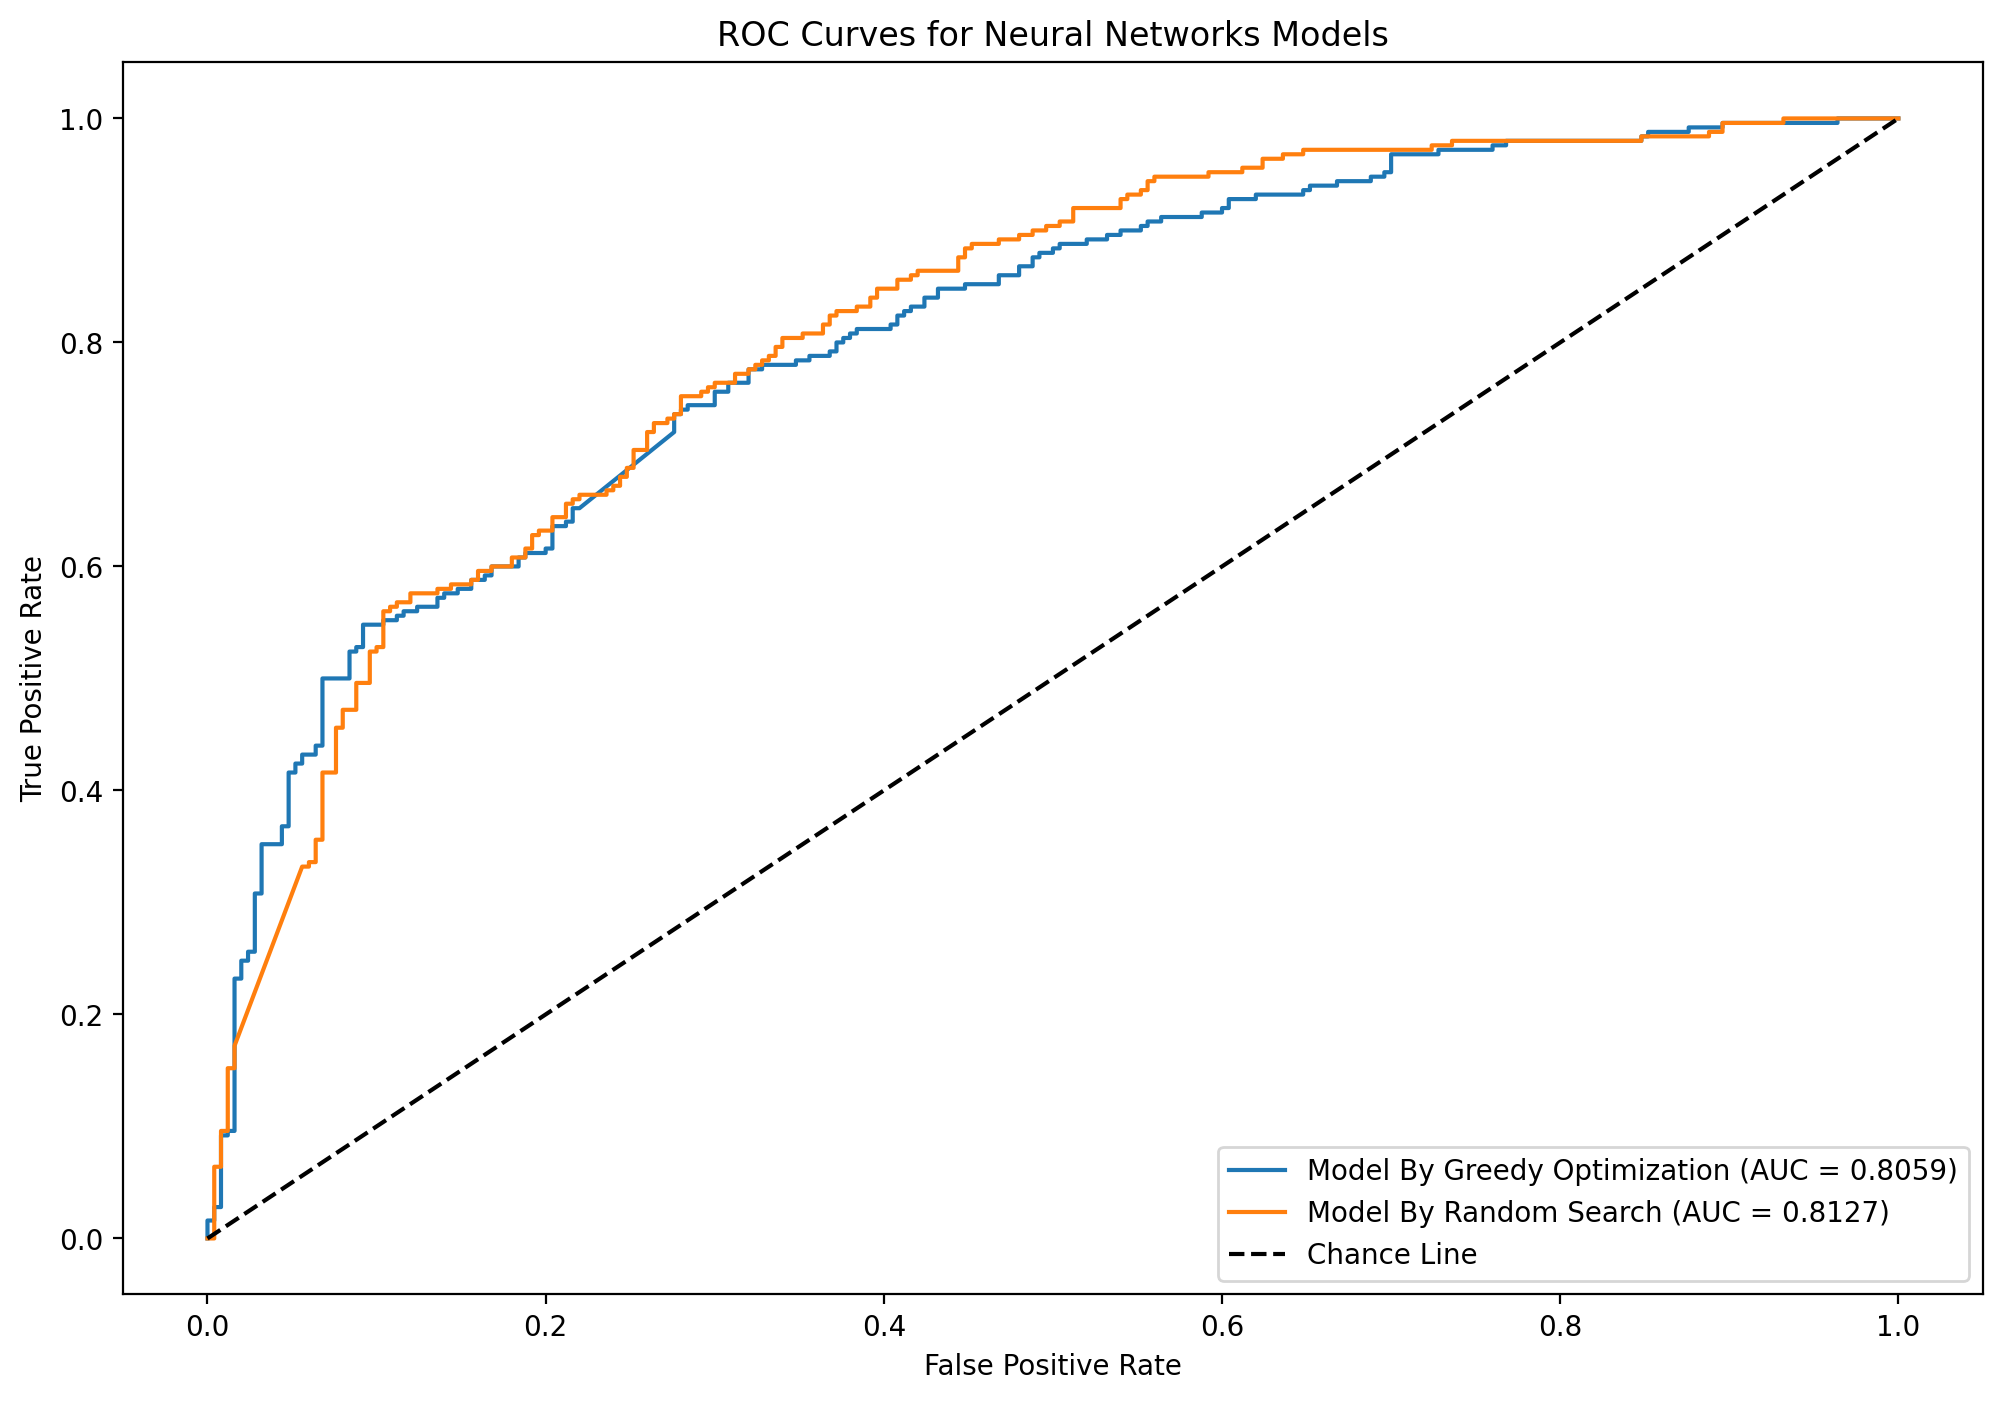

In [127]:
# Plotting the ROC curve for the greedy optimization model
y_pred_proba_optimized = mlp_clf_optimized.predict_proba(X_test)[:, 1]
fpr_greedy_optimized, tpr_greedy_optimized, _ = roc_curve(
    y_test, y_pred_proba_optimized
)
roc_auc_greedy_optimized = auc(fpr_greedy_optimized, tpr_greedy_optimized)

# Plotting the ROC curve for the random search model
y_pred_proba_random_search = best_clf.predict_proba(X_test)[:, 1]
fpr_random_search, tpr_random_search, _ = roc_curve(y_test, y_pred_proba_random_search)
roc_auc_random_search = auc(fpr_random_search, tpr_random_search)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(
    fpr_greedy_optimized,
    tpr_greedy_optimized,
    label=f"Model By Greedy Optimization (AUC = {roc_auc_greedy_optimized:.4f})",
)
plt.plot(
    fpr_random_search,
    tpr_random_search,
    label=f"Model By Random Search (AUC = {roc_auc_random_search:.4f})",
)
plt.plot([0, 1], [0, 1], "k--", label="Chance Line")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Neural Networks Models")
plt.legend(loc="lower right")
plt.show()

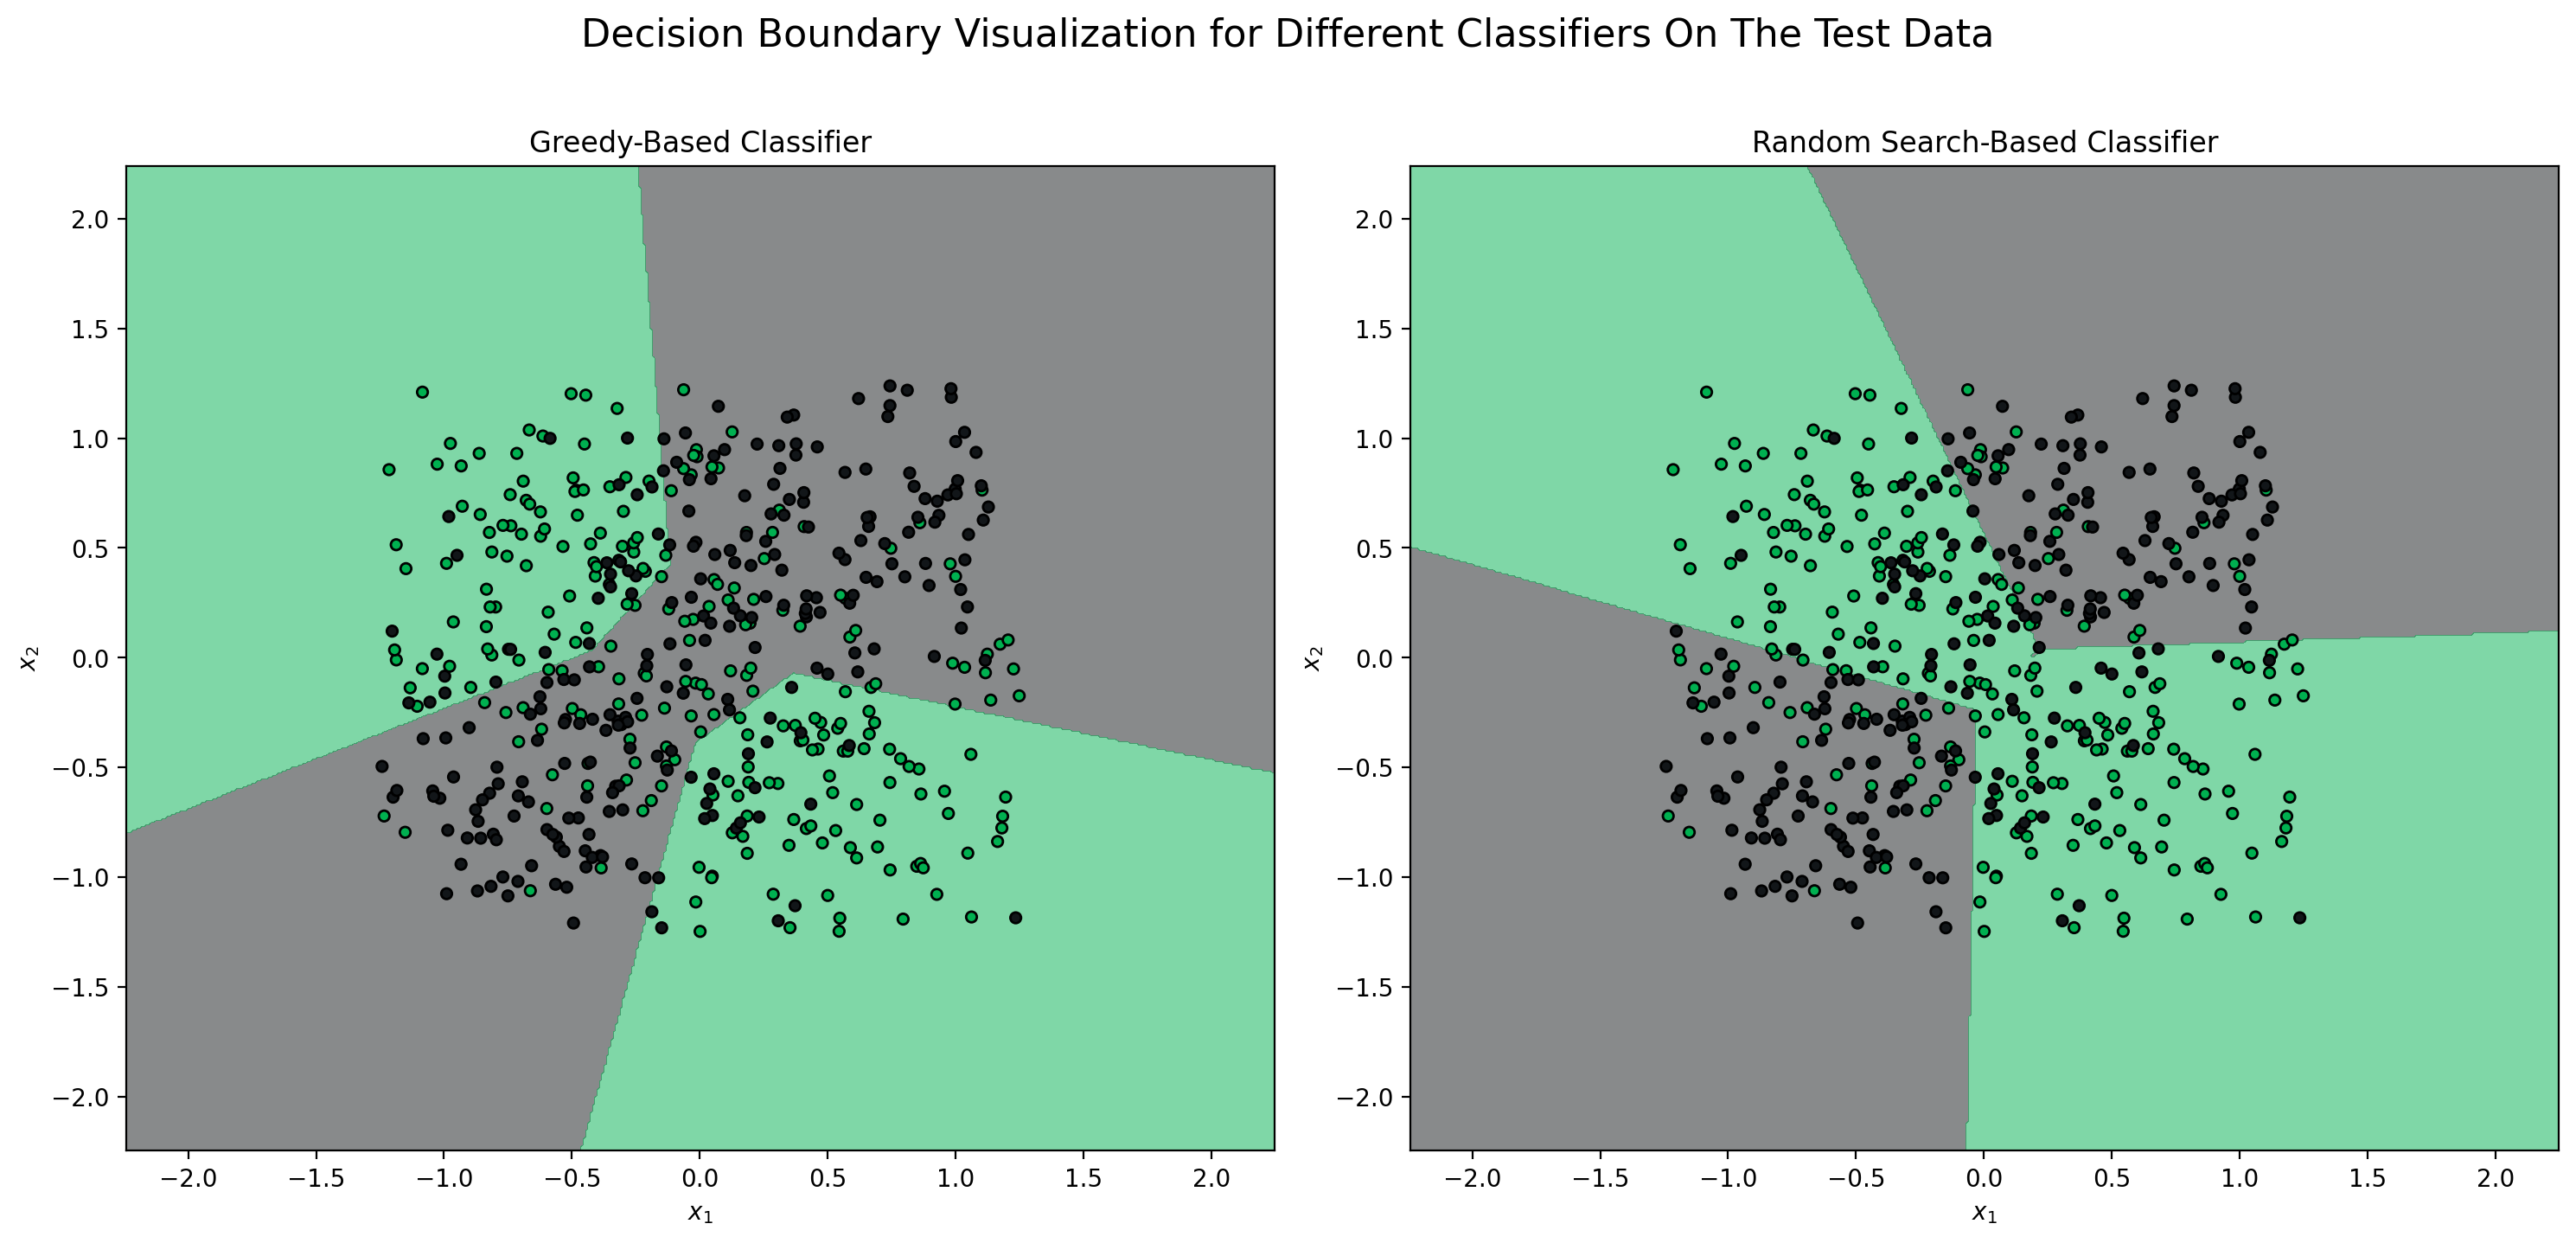

In [128]:
# Generate a mesh grid to plot the decision boundaries
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot decision boundary for the greedy optimization model
ax[0].contourf(
    xx,
    yy,
    mlp_clf_optimized.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape),
    alpha=0.5,
    levels=np.linspace(0, 1, 3),
    cmap=mcolors.ListedColormap(["#121619", "#00B050"]),
)
ax[0].scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap=mcolors.ListedColormap(["#121619", "#00B050"]),
    edgecolor="k",
    s=20,
)
ax[0].set_title("Greedy-Based Classifier")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")

# Plot decision boundary for the random search model
ax[1].contourf(
    xx,
    yy,
    best_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape),
    alpha=0.5,
    levels=np.linspace(0, 1, 3),
    cmap=mcolors.ListedColormap(["#121619", "#00B050"]),
)
ax[1].scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap=mcolors.ListedColormap(["#121619", "#00B050"]),
    edgecolor="k",
    s=20,
)
ax[1].set_title("Random Search-Based Classifier")
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")

# Add a big title for all subplots
plt.suptitle(
    "Decision Boundary Visualization for Different Classifiers On The Test Data",
    fontsize=16,
    y=1.02,
)

plt.tight_layout()
plt.show()

In [130]:
# Calculate differences
difference_auc = roc_auc_random_search - roc_auc_greedy_optimized
difference_accuracy = test_accuracy_random_search - test_accuracy_greedy_optimization

# Determine better model for AUC
if difference_auc > 0:
    print(
        f"Random Search-Based Classifier has a higher AUC by {abs(difference_auc):.4f} points."
    )
else:
    print(
        f"Greedy-Based Classifier has a higher AUC by {abs(difference_auc):.4f} points."
    )

# Determine better model for Accuracy
if difference_accuracy > 0:
    print(
        f"Random Search-Based Classifier has a higher accuracy by {abs(difference_accuracy):.4f} percentage points."
    )
else:
    print(
        f"Greedy-Based Classifier has a higher accuracy by {abs(difference_accuracy):.4f} percentage points."
    )

# Overall report
if difference_auc > 0 and difference_accuracy > 0:
    print(
        "Overall, the Random Search-Based Classifier performs better across both metrics."
    )
elif difference_auc < 0 and difference_accuracy < 0:
    print("Overall, the Greedy-Based Classifier performs better across both metrics.")
else:
    print("The two classifiers excel in different metrics.")

Random Search-Based Classifier has a higher AUC by 0.0067 points.
Random Search-Based Classifier has a higher accuracy by 0.0200 percentage points.
Overall, the Random Search-Based Classifier performs better across both metrics.


> The generalization performance of the hyperparameters selected through the random search outperformed the generalization performance of the hyperparameters selected through manual, greedy search. 

# 2

## [30 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a) [10 points of the 30]** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**NOTE: Due to the depth this question requires, some students may choose not to complete this section (in lieu of receiving the 10 points from this question). If you choose not to build your own neural network, or if your neural network is not functional prior to submission, then use the `scikit-learn` implementation instead in the questions below; where it asks to compare to `scikit-learn`, compare against a random forest classifier instead.**

**ANSWER**

In [280]:
# neural network class skeleton code


class myNeuralNetwork(object):

    def __init__(
        self, n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=0.01, seed=None
    ):
        """__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs,
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        """
        if seed is not None:
            np.random.seed(seed)

        self.n_in = n_in  # number of inputs
        self.n_layer1 = n_layer1  # number of nodes in hidden layer 1
        self.n_layer2 = n_layer2  # number of nodes in hidden layer 2
        self.n_out = n_out  # number of output nodes
        self.learning_rate = learning_rate  # learning rate for gradient descent
        self.x = None  # initialize input

        inputs_layer1 = n_in
        output_layer1 = n_layer1
        # initialize the weights for layer 1
        self.W1 = np.random.randn(output_layer1, inputs_layer1)
        # initialize the bias for layer 1
        self.b1 = np.ones((output_layer1, 1))
        # initialize output for layer 1
        self.A1 = None
        # initialize output for layer 1 after activation
        self.Z1 = None
        # initialize derivatives for layer 1
        self.dZ1 = None
        self.dA1 = None
        self.dW1 = None
        self.db1 = None

        inputs_layer2 = n_layer1
        output_layer2 = n_layer2
        # initialize the weights for layer 2
        self.W2 = np.random.randn(output_layer2, inputs_layer2)
        # initialize the bias for layer 2
        self.b2 = np.ones((output_layer2, 1))
        # initialize output for layer 2
        self.A2 = None
        # initialize output for layer 2 after activation
        self.Z2 = None
        # initialize derivatives for layer 2
        self.dZ2 = None
        self.dA2 = None
        self.dW2 = None
        self.db2 = None

        inputs_layer3 = n_layer2
        output_layer3 = n_out
        # initialize the weights for layer 3
        self.W3 = np.random.randn(output_layer3, inputs_layer3)
        # initialize the bias for layer 3
        self.b3 = np.ones((output_layer3, 1))
        # initialize output for layer 3
        self.A3 = None
        # initialize output for layer 3 after activation
        self.y_hat = None
        # initialize derivatives for layer 3
        self.dy_hat = None
        self.dA3 = None
        self.dW3 = None
        self.db3 = None

    def forward_propagation(self, x):
        """forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        """
        try:
            x = np.array(x)

            # Check the shape of x to ensure it matches the expected input dimensions
            if x.shape[0] != self.n_in or len(x.shape) != 2 or x.shape[1] != 1:
                raise ValueError(
                    f"Input x must be of shape ({self.n_in}, 1). Received shape {x.shape}."
                )

            self.x = x
            # Calculate layer 1 output
            self.A1 = np.dot(self.W1, self.x) + self.b1
            # Calculate layer 1 output with initialization
            self.Z1 = self.sigmoid(self.A1)
            # Caculate layer 2 output
            self.A2 = np.dot(self.W2, self.Z1) + self.b2
            # Calculate layer 2 output with initialization
            self.Z2 = self.sigmoid(self.A2)
            # Calculate layer 3 output
            self.A3 = np.dot(self.W3, self.Z2) + self.b3
            # Calculate layer 3 output with initialization
            self.y_hat = self.sigmoid(self.A3)

            return self.y_hat

        # error handling
        except ValueError as e:
            print(f"ValueError: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    def compute_loss(self, X, y):
        """compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function. It is used as an aggregate performance
        metric to evaluate and monitor the model's ability to generalize
        across the dataset.
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        """
        try:
            # Ensure X and y are numpy arrays
            X = np.array(X)
            y = np.array(y).reshape(-1, 1)  # Ensure y is a column vector

            # Validate input dimensions
            # X.shape= (samples, dimension of X)
            # y.shape= (samples, )
            if X.shape[1] != self.n_in:
                raise ValueError(
                    f"Expected input dimension {self.n_in}, got {X.shape[1]}"
                )
            if y.shape[0] != X.shape[0]:
                raise ValueError(
                    f"Mismatch in number of samples: X has {X.shape[0]}, y has {y.shape[0]}"
                )

            # Use predict_proba to get predictions for X
            y_hat_total = self.predict_proba(X)

            # Compute the cross entropy loss
            epsilon = 1e-15  # to prevent log(0)
            y_hat_clipped = np.clip(
                y_hat_total, epsilon, 1 - epsilon
            )  # clip predictions for stability
            loss = -np.mean(
                y * np.log(y_hat_clipped) + (1 - y) * np.log(1 - y_hat_clipped)
            )

            return loss

        # error handling
        except ValueError as e:
            print(f"ValueError: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    def backpropagate(self, x, y):
        """backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations
               Corresponding to x and get the loss function of the model
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of the loss/cost associated with x,y
                      and the current model weights
        """
        try:
            x = np.array(x)
            y = np.array(y)

            # Input validation checks
            if x.ndim != 2 or x.shape[1] != 1:
                raise ValueError(
                    f"Input x must be of shape ({self.n_in}, 1). Received shape {x.shape}."
                )
            if not isinstance(y, (np.ndarray, float, int)):
                raise ValueError("Target y must be a numpy array, float, or int.")
            if isinstance(y, np.ndarray) and (y.ndim != 2 or y.shape[1] != 1):
                raise ValueError(
                    f"Target y must be of shape (1, 1) for a single sample. Received shape {y.shape}."
                )

            # Forward propagation to get predictions
            y_hat = self.forward_propagation(x)

            # Compute the cross-entropy loss for a single sample
            epsilon = 1e-15  # to prevent log(0)
            y_hat_clipped = np.clip(
                y_hat, epsilon, 1 - epsilon
            )  # clip predictions for stability
            loss = -(y * np.log(y_hat_clipped) + (1 - y) * np.log(1 - y_hat_clipped))

            # Compute the derivative of cross-entropy loss with respect to the output (y_hat)
            dloss = -(y / y_hat_clipped - (1 - y) / (1 - y_hat_clipped))

            # derivatives of layer 3
            self.dy_hat = dloss
            self.dA3 = dloss * self.sigmoid_derivative(self.A3)
            self.dW3 = np.dot(self.dA3, self.Z2.T)
            self.db3 = np.sum(self.dA3, axis=1, keepdims=True)

            # derivatives of layer 2
            self.dZ2 = np.dot(self.W3.T, self.dA3)
            self.dA2 = self.dZ2 * self.sigmoid_derivative(self.A2)
            self.dW2 = np.dot(self.dA2, self.Z1.T)
            self.db2 = np.sum(self.dA2, axis=1, keepdims=True)

            # derivatives of layer 1
            self.dZ1 = np.dot(self.W2.T, self.dA2)
            self.dA1 = self.dZ1 * self.sigmoid_derivative(self.A1)
            self.dW1 = np.dot(self.dA1, self.x.T)
            self.db1 = np.sum(self.dA1, axis=1, keepdims=True)

            # updating parameters in layer 3
            self.W3 = self.W3 - self.learning_rate * self.dW3
            self.b3 = self.b3 - self.learning_rate * self.db3

            # updating parameters in layer 2
            self.W2 = self.W2 - self.learning_rate * self.dW2
            self.b2 = self.b2 - self.learning_rate * self.db2

            # updating parameters in layer 1
            self.W1 = self.W1 - self.learning_rate * self.dW1
            self.b1 = self.b1 - self.learning_rate * self.db1

            return loss

        # error handling
        except ValueError as e:
            print(f"ValueError: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

    def fit(
        self,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        max_epochs=100,
        initial_learning_rate=0.01,
        get_validation_loss=False,
        lr_decay_epoch=10,
        lr_decay_factor=0.9,
        seed=None,
    ):
        """fit
        Input:
            X_train: A matrix of N samples of data [N x n_in]
            y_train: Target variable [N x 1]
            X_val: A matrix of validation samples of data [N_val x n_in] (optional)
            y_val: Target variable for validation data [N_val x 1] (optional)
            max_epochs: Maximum number of epochs for training
            initial_learning_rate: Initial learning rate for gradient descent
            get_validation_loss: Flag to compute validation loss
            lr_decay_epoch: Number of epochs after which learning rate should be decayed
            lr_decay_factor: Factor by which learning rate should be decayed
        Output:
            training_loss: Vector of training loss values at the end of each epoch
            validation_loss: Vector of validation loss values at the end of each epoch (if get_validation_loss is True)
        """

        if seed is not None:
            np.random.seed(seed)

        # Initialize loss tracking lists
        training_loss = []
        validation_loss = []

        # Set initial learning rate
        self.learning_rate = initial_learning_rate

        # Iterate through epochs
        for epoch in range(max_epochs):
            # Learning rate schedule: Decay learning rate
            if epoch > 0 and epoch % lr_decay_epoch == 0:
                self.learning_rate *= lr_decay_factor
                # print(
                # f"Decaying learning rate to {self.learning_rate} at epoch {epoch}"
                # )

            # Shuffle the training data
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            # Iterate through each sample
            for i in range(X_train.shape[0]):
                x_sample = X_train[i, :].reshape(
                    -1, 1
                )  # X_train.shape = (dimension of X, 1)
                y_sample = y_train[i].reshape(-1, 1)  # Ensure y is a column vector

                # Perform forward propagation and backpropagation
                self.backpropagate(x_sample, y_sample)

            # Calculate average loss for the epoch
            # After processing all samples, evaluate performance on the entire dataset
            avg_epoch_training_loss = self.compute_loss(X_train, y_train)
            training_loss.append(avg_epoch_training_loss)

            # Calculate validation loss
            if get_validation_loss and X_val is not None and y_val is not None:
                avg_epoch_validation_loss = self.compute_loss(X_val, y_val)
                validation_loss.append(avg_epoch_validation_loss)

            # print out the loss every few epochs and at the very last
            # if epoch % 10 == 0 or epoch == max_epochs - 1:
            # print(f"Epoch {epoch}: Training Loss = {avg_epoch_training_loss:.4f}")
            # if get_validation_loss:
            # print(
            # f"Epoch {epoch}: Validation Loss = {avg_epoch_validation_loss:.4f}"
            # )

        # Return the loss history
        if get_validation_loss:
            return training_loss, validation_loss
        else:
            return training_loss

    def predict_proba(self, X):
        """predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        """
        try:
            # Ensure X is a numpy array
            X = np.array(X)
            # Validate input dimensions
            if X.ndim == 1:
                X = X.reshape(1, -1)  # Reshape if X is a single sample
            if X.shape[1] != self.n_in:
                raise ValueError(
                    f"Expected input dimension {self.n_in}, got {X.shape[1]}"
                )

            # Initialize an array to store predictions
            y_hat_total = np.zeros((X.shape[0], 1))

            # Iterate over each sample in X
            for i in range(X.shape[0]):
                x_sample = X[i, :].reshape(-1, 1)  # X.shape= (dimension of X, 1)
                y_hat_total[i, 0] = self.forward_propagation(x_sample)

            return y_hat_total

        except ValueError as e:
            print(f"ValueError: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    def predict(self, X, decision_thresh=0.5):
        """predict
        Compute the output of the neural network prediction for
        each sample in X, with the last layer's sigmoid activation
        providing an estimate of the target output between 0 and 1,
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_final_hat: A vector of class predictions of either 0 or 1 [N x 1]
        """
        y_hat = self.predict_proba(X)  # Use predict_proba to get predictions
        y_hat_flat = y_hat.flatten()  # Ensure y_hat is flattened for iteration
        y_predicted_cls = [
            1 if i > decision_thresh else 0 for i in y_hat_flat
        ]  # apply binary decision rule
        y_final_hat = np.array(y_predicted_cls)

        return y_final_hat

    def sigmoid(self, X):
        """sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        """
        return 1 / (1 + np.exp(-X))

    def sigmoid_derivative(self, X):
        """sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        """
        return self.sigmoid(X) * (1 - self.sigmoid(X))

**(b)** Apply your neural network. 
- Create training, validation, and test datasets using `sklearn.datasets.make_moons(N, noise=0.20)` data, where $N_{train} = 500$ and $N_{test} = 100$. The validation dataset should be a portion of your training dataset that you hold out for hyperparameter tuning.
- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 
- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead. Be sure to set the hidden layer sizes, epochs, and learning rate for that model, if so.*
- **Remember to retrain your model.** After selecting your hyperparameters using the validation data set, when evaluating the final performance on the ROC curve, it's good practice to retrain your model with the selected hyperparameters on the train + validation dataset, before evaluating on the test data. 

Note if you opted not to build your own neural network: in this case, for hyperparameter tuning, we recommend using the `partial_fit` method to train your model for every epoch. Partial fit allows you to incrementally fit on one sample at a time.



**ANSWER**

- Create training, validation, and test datasets using `sklearn.datasets.make_moons(N, noise=0.20)` data, where $N_{train} = 500$ and $N_{test} = 100$. The validation dataset should be a portion of your training dataset that you hold out for hyperparameter tuning.

In [219]:
# Dataset sizes
N_train = 500
N_test = 100

# Generate the datasets
X_moon, y_moon = make_moons(n_samples=N_train + N_test, noise=0.20, random_state=seed)

# Split the dataset into a temporary training+validation dataset and the final test dataset
X_temp_train_m, X_test_m, y_temp_train_m, y_test_m = train_test_split(
    X_moon, y_moon, test_size=N_test, random_state=seed
)

# Further split the temporary dataset into the final training dataset(80%) and the validation dataset (20%)
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(
    X_temp_train_m, y_temp_train_m, test_size=0.20, random_state=seed
)

- **Cost function plots**. Train and validate your model on this dataset plotting your training and validation cost learning curves on the same set of axes. This is the training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time. 

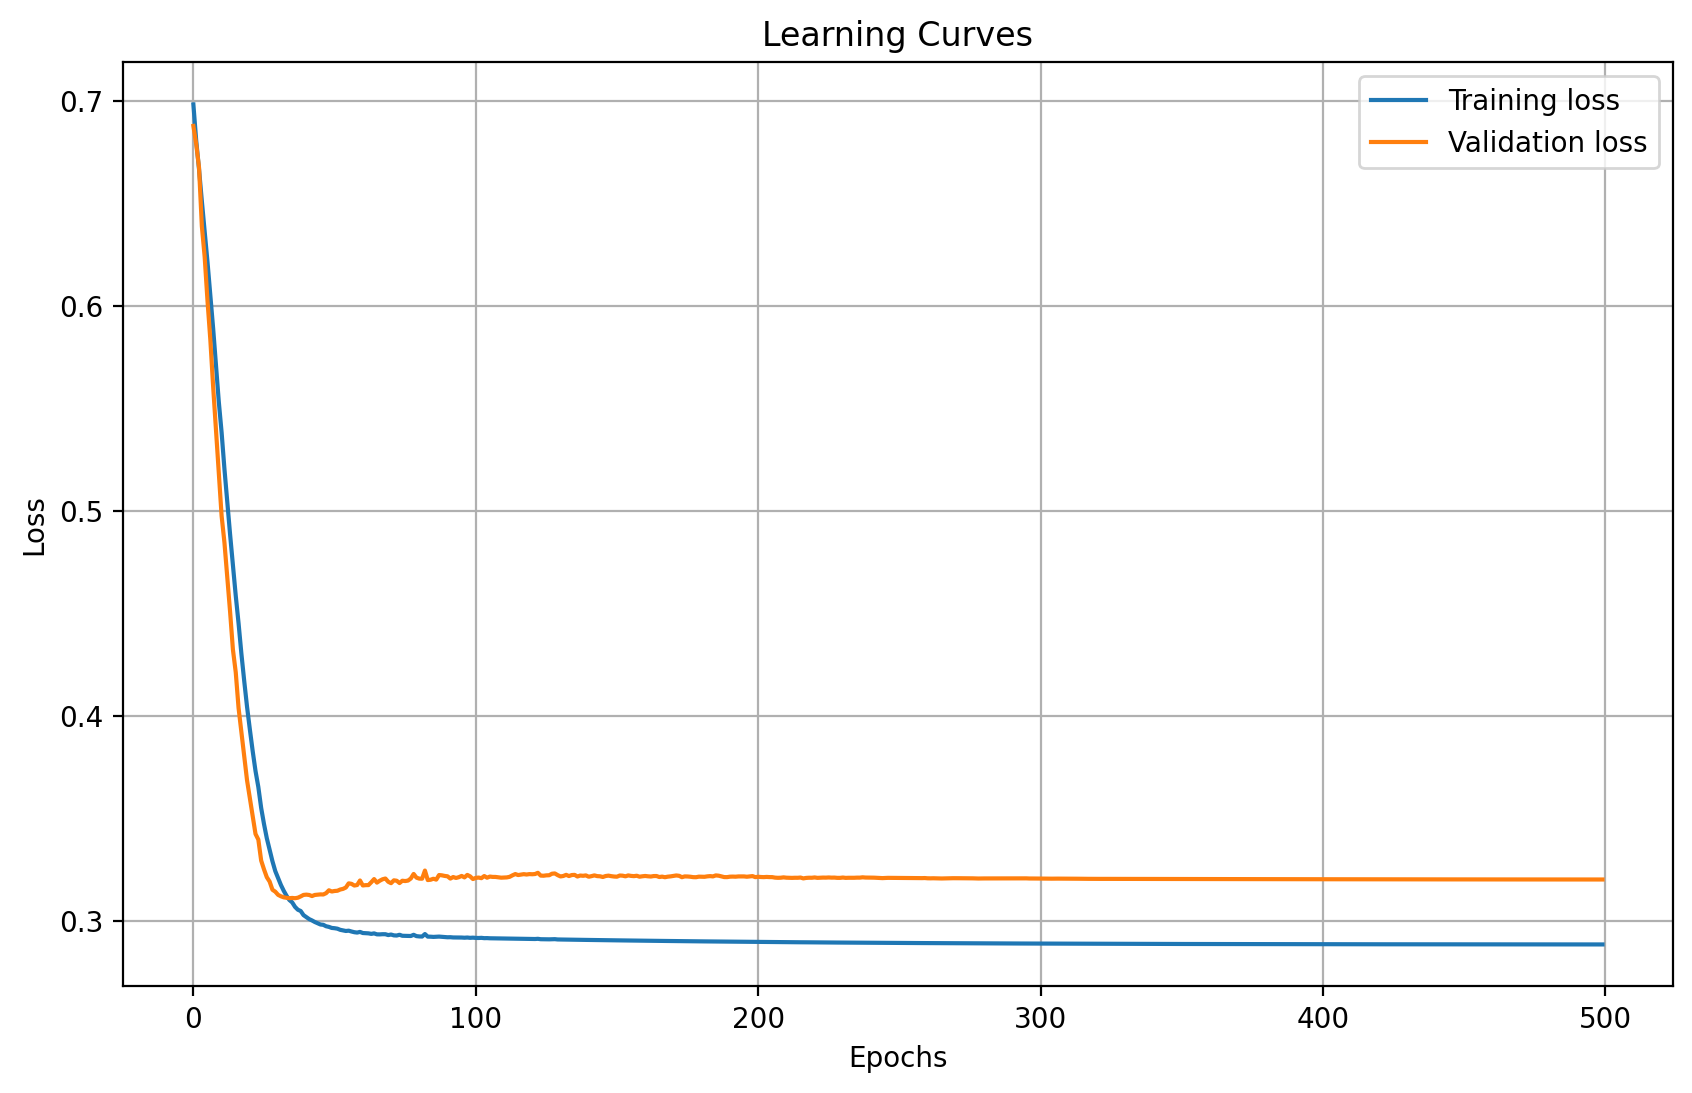

In [242]:
# Initialize the neural network
nn = myNeuralNetwork(
    n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=0.01, seed=seed
)

# Train the network
training_loss, validation_loss = nn.fit(
    X_train_m,
    y_train_m,
    X_val_m,
    y_val_m,
    max_epochs=500,
    initial_learning_rate=0.01,
    lr_decay_epoch=10,
    lr_decay_factor=0.9,
    get_validation_loss=True,
    seed=seed,
)

# Cost Function Plot
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.title("Learning Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

- Tune the learning rate and number of training epochs for your model to improve performance as needed. You're free to use any methods you deem fit to tune your hyperparameters like grid search, random search, Bayesian optimization etc. 

In [221]:
# Define hyperparameters distributions to sample from
param_dist_dic = {
    "max_epochs": [25, 50, 75, 100, 125, 150, 175, 200, 225, 250],
    "initial_learning_rate": loguniform(1e-5, 1e-1),
    "lr_decay_epoch": [5, 10, 15, 20],
    "lr_decay_factor": [0.5, 0.7, 0.9],
}


# Function to run random search
def random_search(X_train, y_train, X_val, y_val, param_dist, iterations, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # set placeholder values for best score and best parameters
    best_score = np.inf
    best_params = None

    for i in range(iterations):
        # Sample parameters
        params = {
            k: v.rvs() if hasattr(v, "rvs") else np.random.choice(v)
            for k, v in param_dist.items()
        }

        # Train the model
        rnn = myNeuralNetwork(
            n_in=2,
            n_layer1=5,
            n_layer2=5,
            n_out=1,
            learning_rate=params["initial_learning_rate"],
            seed=seed,
        )

        training_loss, validation_loss = rnn.fit(
            X_train,
            y_train,
            X_val,
            y_val,
            max_epochs=params["max_epochs"],
            initial_learning_rate=params["initial_learning_rate"],
            lr_decay_epoch=params["lr_decay_epoch"],
            lr_decay_factor=params["lr_decay_factor"],
            get_validation_loss=True,
            seed=seed,
        )

        # print(f"final validation loss={validation_loss[-1]}.")

        # Update best score and parameters
        if validation_loss[-1] < best_score:
            best_score = validation_loss[-1]
            best_params = params
            # print(f"New best score: {best_score:.4f}")
            # print(f"Parameters: {best_params}")

    return best_params, best_score


# Start random search
start_time = time()
best_hyperparameters, best_validation_score = random_search(
    X_train=X_train_m,
    y_train=y_train_m,
    X_val=X_val_m,
    y_val=y_val_m,
    param_dist=param_dist_dic,
    iterations=100,
    seed=seed,
)
end_time = time()

print(f"Random search took {end_time - start_time:.2f} seconds.")
print(f"Best hyperparameters found: {best_hyperparameters}")
print(f"Best validation score (lowest validation loss): {best_validation_score:.4f}")

Random search took 476.32 seconds.
Best hyperparameters found: {'max_epochs': 200, 'initial_learning_rate': 0.08127705810666684, 'lr_decay_epoch': 5, 'lr_decay_factor': 0.9}
Best validation score (lowest validation loss): 0.1534


- **Decision boundary plots**. In two subplots, plot the training data on one subplot and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 

In [256]:
# train the model on the best hyperparameters
nn_optimized = myNeuralNetwork(
    n_in=2,
    n_layer1=5,
    n_layer2=5,
    n_out=1,
    learning_rate=best_hyperparameters["initial_learning_rate"],
    seed=seed,
)
training_loss, validation_loss = nn_optimized.fit(
    X_train_m,
    y_train_m,
    X_val_m,
    y_val_m,
    max_epochs=best_hyperparameters["max_epochs"],
    initial_learning_rate=best_hyperparameters["initial_learning_rate"],
    lr_decay_epoch=best_hyperparameters["lr_decay_epoch"],
    lr_decay_factor=best_hyperparameters["lr_decay_factor"],
    get_validation_loss=True,
    seed=seed,
)

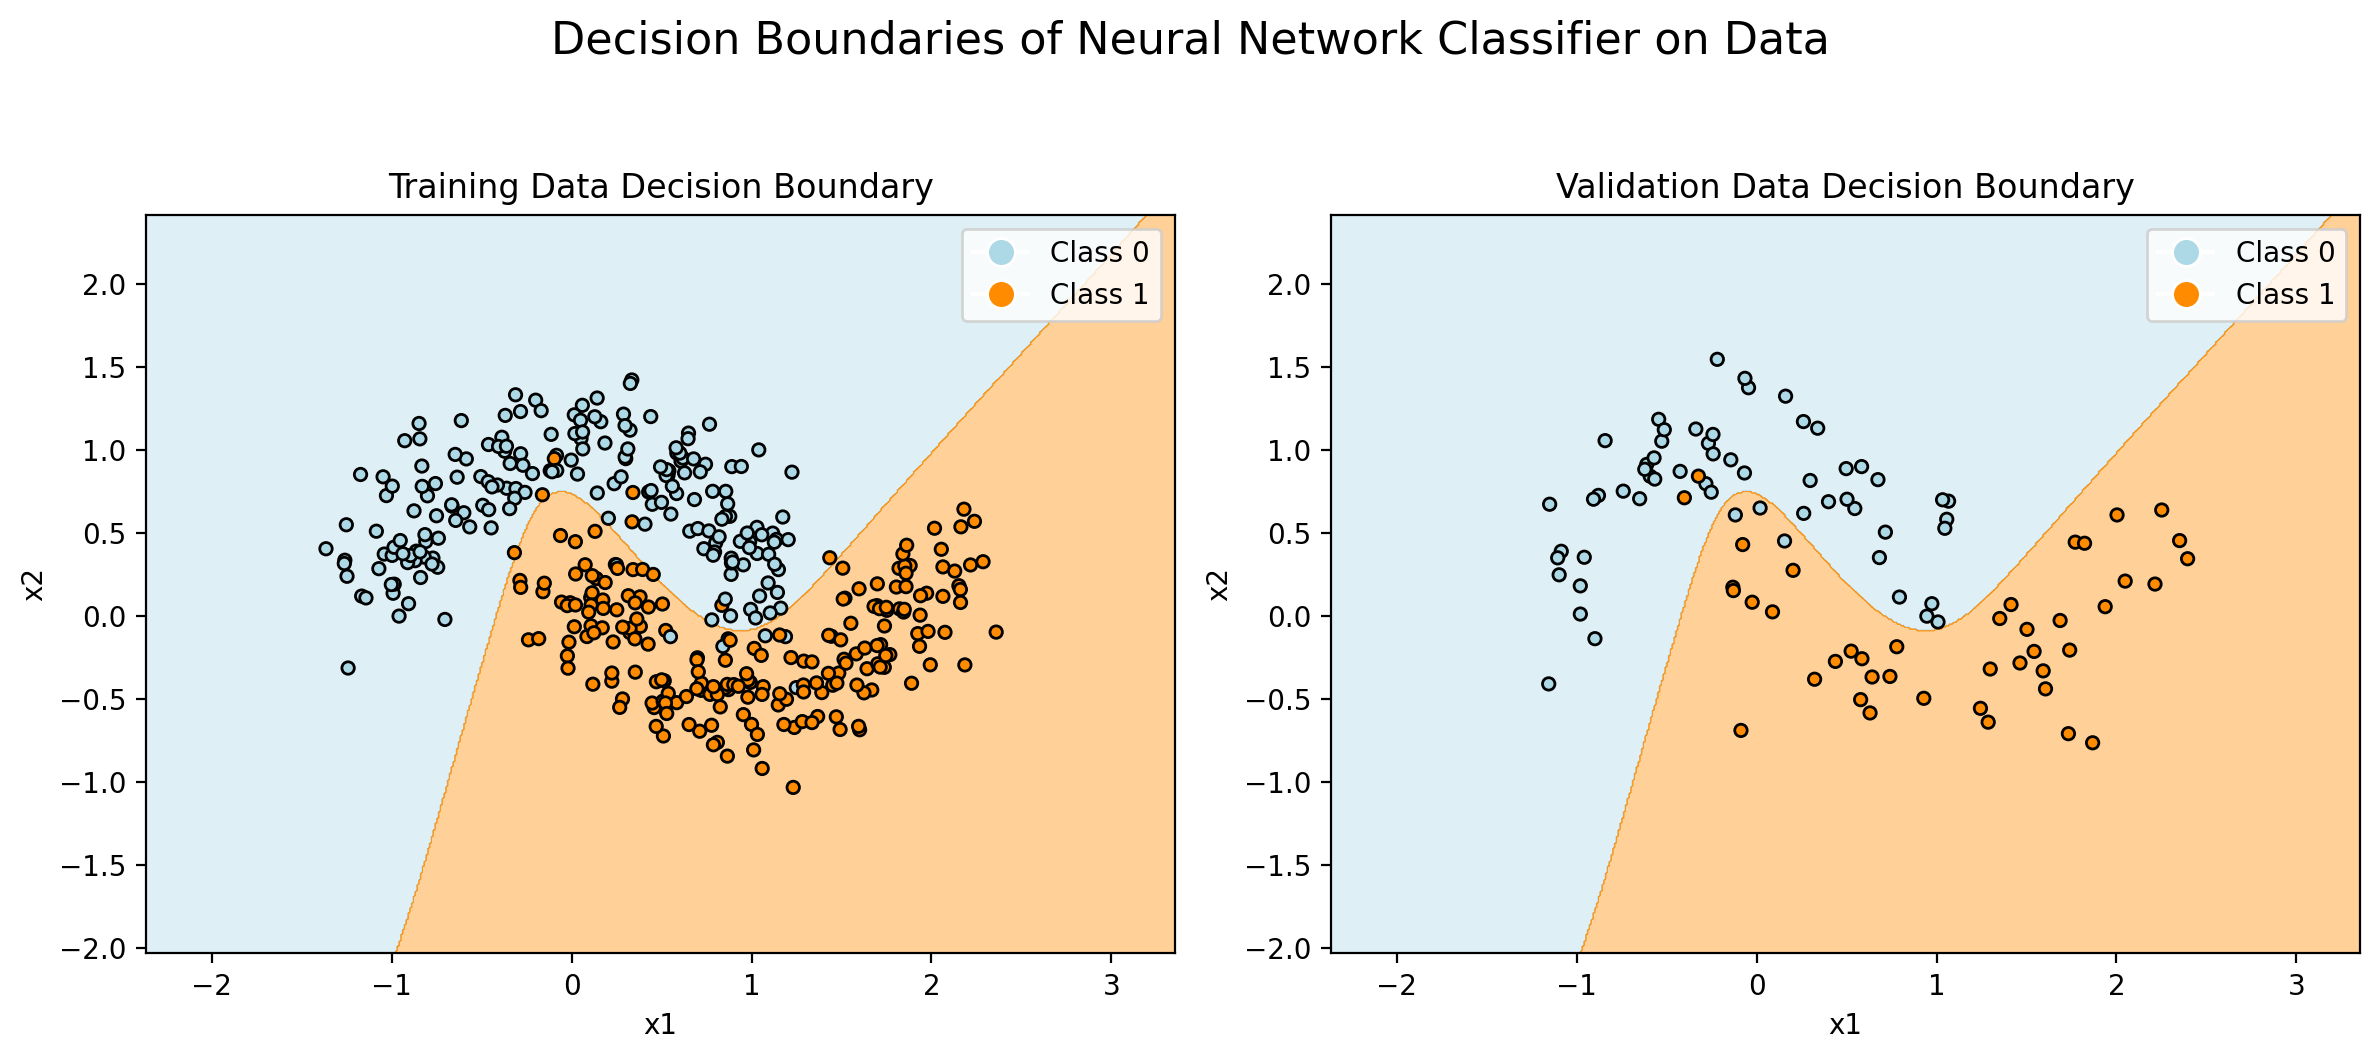

In [257]:
# Colors for plotting
color0 = "#ADD8E6"  # Light blue for class 0
color1 = "#FF8C00"  # Deep orange for class 1
colors = [color0, color1]
cmap = mcolors.ListedColormap(colors)

# Generate a mesh grid to plot the decision boundaries
x_min, x_max = X_train_m[:, 0].min() - 1, X_train_m[:, 0].max() + 1
y_min, y_max = X_train_m[:, 1].min() - 1, X_train_m[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict over the grid
Z = nn_optimized.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot decision boundary on training data
contour_train = ax[0].contourf(xx, yy, Z, cmap=cmap, alpha=0.4)
scatter_train = ax[0].scatter(
    X_train_m[:, 0], X_train_m[:, 1], c=y_train_m, cmap=cmap, edgecolor="k", s=20
)
ax[0].set_title("Training Data Decision Boundary")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")

# Plot decision boundary on validation data
contour_val = ax[1].contourf(xx, yy, Z, cmap=cmap, alpha=0.4)
scatter_val = ax[1].scatter(
    X_val_m[:, 0], X_val_m[:, 1], c=y_val_m, cmap=cmap, edgecolor="k", s=20
)
ax[1].set_title("Validation Data Decision Boundary")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")

# Create legend for classes with colors consistent with the class regions and samples
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Class 0",
        markerfacecolor=color0,
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Class 1",
        markerfacecolor=color1,
        markersize=10,
    ),
]
ax[0].legend(handles=legend_elements, loc="upper right")
ax[1].legend(handles=legend_elements, loc="upper right")

# Add a large title above the subplots
fig.suptitle(
    "Decision Boundaries of Neural Network Classifier on Data", fontsize=16, y=1.05
)

plt.tight_layout()
plt.show()

- **ROC Curve plots**. Report your performance on the test data with an ROC curve and the corresponding AUC score. Compare against the `scikit-learn` `MLPClassifier` trained with the same parameters on the same set of axes and include the chance diagonal. *Note: if you chose not to build your own neural network in part (a) above, or if your neural network is not functional prior to submission, then use the `scikit-learn` `MLPClassifier` class instead for the neural network and compare it against a random forest classifier instead. Be sure to set the hidden layer sizes, epochs, and learning rate for that model, if so.*
- **Remember to retrain your model.** After selecting your hyperparameters using the validation data set, when evaluating the final performance on the ROC curve, it's good practice to retrain your model with the selected hyperparameters on the train + validation dataset, before evaluating on the test data. 

In [273]:
# Combine training and validation sets
X_train_val_m = X_temp_train_m
y_train_val_m = y_temp_train_m

# Retrain the model on the combined dataset
nn_optimized_retrained = myNeuralNetwork(
    n_in=2,
    n_layer1=5,
    n_layer2=5,
    n_out=1,
    learning_rate=best_hyperparameters["initial_learning_rate"],
    seed=seed,
)

# fit the nn classifier
retrained_training_loss = nn_optimized_retrained.fit(
    X_train=X_train_val_m,
    y_train=y_train_val_m,
    max_epochs=best_hyperparameters["max_epochs"],
    initial_learning_rate=best_hyperparameters["initial_learning_rate"],
    lr_decay_epoch=best_hyperparameters["lr_decay_epoch"],
    lr_decay_factor=best_hyperparameters["lr_decay_factor"],
    get_validation_loss=False,  # No validation split
    seed=seed,
)

In [274]:
# train MLP Classifier with the same parameters as my own NN
mlp_same_optimized = MLPClassifier(
    hidden_layer_sizes=(5, 5),  # Equivalent to n_layer1=5, n_layer2=5
    activation="logistic",  # sigmoid activation function
    solver="sgd",  # Stochastic Gradient Descent
    alpha=0,  # L2 penalty (regularization term) parameter, set to 0 for none
    learning_rate_init=best_hyperparameters[
        "initial_learning_rate"
    ],  # same lr as my custom NN
    max_iter=best_hyperparameters["max_epochs"],  # same max epochs as my custom NN
    learning_rate="adaptive",  # Match the learning rate schedule used in my custom NN
    early_stopping=False,  # Match my custom NN no early stopping
    batch_size=1,  # Match my custom NN 1 batch size = 1
    random_state=seed,
)

# Fit the MLPClassifier
mlp_same_optimized.fit(X_train_val_m, y_train_val_m)

MLPClassifier(activation='logistic', alpha=0, batch_size=1,
              hidden_layer_sizes=(5, 5), learning_rate='adaptive',
              learning_rate_init=0.08127705810666684, random_state=42,
              solver='sgd')

In [277]:
# Predictions on test data using MLPClassifier
y_pred_mlp = mlp_same_optimized.predict(X_test_m)

# Calculate accuracy for MLPClassifier
accuracy_mlp = accuracy_score(y_test_m, y_pred_mlp)
print(f"MLPClassifier Test Accuracy: {accuracy_mlp:.4f}")

# Predictions on test data using Neural Network
y_pred_nn = nn_optimized_retrained.predict(X_test_m)

# Calculate accuracy for Neural Network
accuracy_nn = accuracy_score(y_test_m, y_pred_nn)
print(f"Custom Neural Network Test Accuracy: {accuracy_nn:.4f}")

MLPClassifier Test Accuracy: 0.9500
Custom Neural Network Test Accuracy: 0.9400


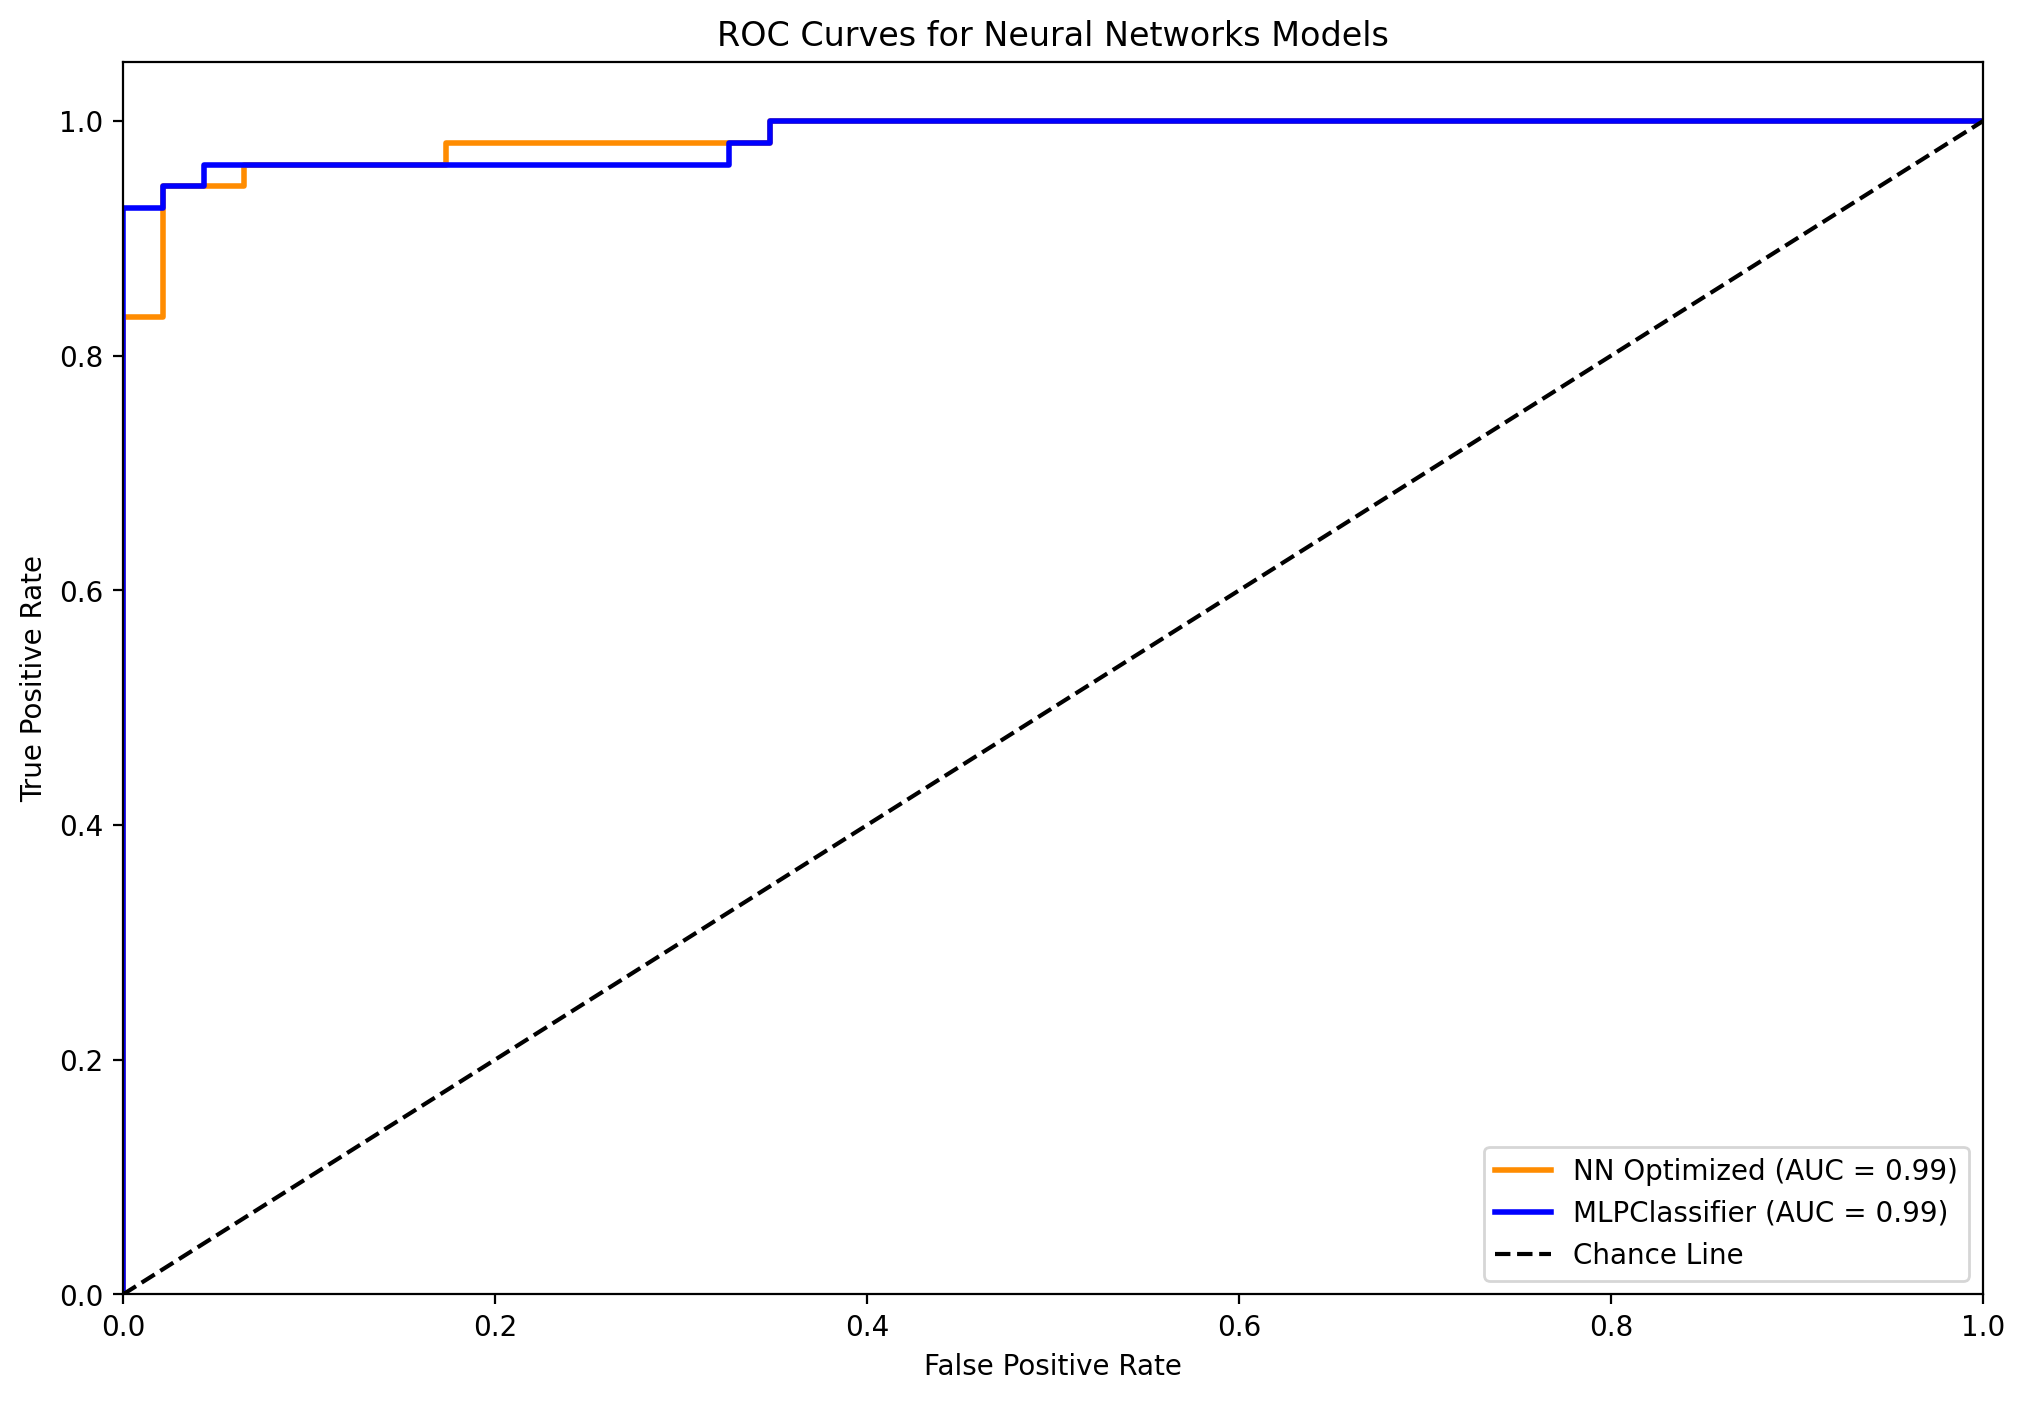

In [278]:
# Get probability scores of the positive class
y_scores_nn = nn_optimized_retrained.predict_proba(X_test_m)
y_scores_mlp = mlp_same_optimized.predict_proba(X_test_m)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_nn, tpr_nn, _ = roc_curve(y_test_m, y_scores_nn)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_m, y_scores_mlp)
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(
    fpr_nn,
    tpr_nn,
    label=f"NN Optimized (AUC = {roc_auc_nn:.2f})",
    color="darkorange",
    lw=2,
)
plt.plot(
    fpr_mlp,
    tpr_mlp,
    label=f"MLPClassifier (AUC = {roc_auc_mlp:.2f})",
    color="blue",
    lw=2,
)
plt.plot([0, 1], [0, 1], "k--", label="Chance Line")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Neural Networks Models")
plt.legend(loc="lower right")
plt.show()

> Both custom Neural Network model and the sklearn MLPClassifier shows almost identical performance with AUCs of 0.99. However, in regards of test accuracy, MLPClassifier with a test accuracy score of 0.95 slightly outperforms custom Neural Network model with a test accuracy score of 0.94.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

**ANSWER**

> - **Transition from Stochastic Gradient Descent (SGD) to Mini-batch Gradient Descent**: Currently I use SGD to update weights using a single training sample at a time. This approach can be noisy and lead to slow convergence. Mini-batch Gradient Descent processes several training samples (a mini-batch) at once. This method strikes a balance between the efficiency of batch gradient descent and the robustness of SGD. It helps in smoothing out the variance in the weight updates, leading to more stable convergence.
> - **Incorporating Batch Normalization**: By implementing batch normalization, I can standardize the inputs to each layer for every mini-batch. This involves calculating the activation for each training sample within a mini-batch, and then for each mini-batch, computing the mean and standard deviation of these activations. The next step is to normalize the activations by subtracting the computed mean and dividing by the standard deviation. This normalization process ensures that the activations maintain a consistent scale and distribution across mini-batches, significantly stabilizing the learning process throughout the network. Such stabilization is crucial as it allows for the use of higher learning rates, which in turn accelerates the training process convergence, leading to faster optimization and improved network performance.

---

## Citation 

Aflak, O. (2021, May 24). Neural Network from scratch in Python - Towards Data Science. Medium. https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65 

Kumar, N. (2021, December 9). Building a Feedforward Neural Network from Scratch in Python. Medium. https://medium.com/hackernoon/building-a-feedforward-neural-network-from-scratch-in-python-d3526457156b 

Menon, A. (2021, December 14). Neural Networks from Scratch in Python - Towards Data Science. Medium. https://towardsdatascience.com/creating-neural-networks-from-scratch-in-python-6f02b5dd911

I used ChatGPT to check my grammer in Question 2 (c) with the prompt, “Revise the grammer in the following paragraph {}”